### Parte 1. Lectura de datos crudos.
**Libreria de XM para datos del mercado eléctrico**

In [171]:
# Instalación de libreria XM
!pip install pydataxm


You should consider upgrading via the 'C:\Users\itco10302\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [172]:
# Libreria lectura de datos XM
from pydataxm import *

#Librerias básicas manejo de datos
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

#Librerias visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import spearmanr



# Librerias análisis exploratorio
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Librerias preparación de datos para modelo
import tensorflow as tf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU



Lectura desde API XM (Administrador del mercado mayorista de energía en Colombia). Base de datos con colecciones y variables del mercado mayorista de energía, en la que converge información relacionada con la demanda energética diaria del país, las diversas fuentes de generación electrica que componen la matriz energética colombiana, despacho térmico para la generación de energía electrica a partir diferentes tipos de combustible, variables históricas de precios, agentes generadores, entre otros.



In [173]:
# Creación de objeto API
objetoAPI = pydataxm.ReadDB()
# Con esta línea de código traemos todas las colecciones de datos de xm
df =objetoAPI.get_collections()
df.head(20)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
5,GeneIdea,Generación Ideal por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Despacho de generacion que resulta de consider...
6,PrecBolsNaci,Precio Bolsa Nacional por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP/kWh,Precio de oferta de la última planta flexible ...
7,RestAliv,Restricciones Aliviadas por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,“Es el valor a cargo de los comercializadores ...
8,ConsCombustibleMBTU,Consumo Combustible MBTU por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,MBTU,Los generadores térmicos deben reportar diaria...
9,Gene,Generación por Recurso,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,kWh,Generacion neta de cada una de las plantas Nac...


### Lectura de datos crudos desde la base de datos de XM de consumo de combustible de los agentes del sistema en MBTU
**Descripción de las variables:**
1.  Id: indicador de recurso
2. Values_Name: Tipo de combustible utilizado para la generación
3. Values_code: Nombre codificado de la central térmica.
4. Values_Hour0"n": Cantidad de energía consumida en MBTU en la hora "n" por el agente termico en un día particular.
5. Date: Día de consumo.

In [174]:
# Lectura de datos crudos del consumo de combustible en MBTU de las termoelectricas durante el periodo 2017-2023.
# Se realiza una lectura de consumo de combustible desde una fecha inicio hasta una fecha fin.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_ConsCombustibleMBTU = objetoAPI.request_data("ConsCombustibleMBTU",
                                    "Recurso",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_ConsCombustibleMBTU

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Recurso,ACPM,TRN1,9.73000,28.13000,27.79000,NaN,NaN,11.81000,2.43000,...,9.38000,9.38000,9.38000,9.38000,19.80000,9.73000,9.38000,9.38000,9.38000,2023-12-26
1,Recurso,CARBON,GE32,2596.83000,2073.22000,1570.20000,1649.84000,1697.32000,1911.22000,2348.90000,...,2915.58000,2902.76000,2907.81000,2902.13000,2899.19000,2900.87000,2893.73000,2902.55000,2901.71000,2023-12-26
2,Recurso,CARBON,GEC3,1859.53000,1899.67000,1892.52000,1895.46000,1893.15000,1888.74000,1886.64000,...,1320.16000,1186.11000,1258.81000,1240.11000,1222.04000,1243.26000,1327.10000,1433.42000,1632.19000,2023-12-26
3,Recurso,CARBON,PPA1,345.95685,327.42046,305.82954,272.77367,234.32007,258.33788,295.53619,...,376.66952,378.97087,378.59429,374.66106,369.55623,376.54399,380.01695,375.66529,371.85759,2023-12-26
4,Recurso,CARBON,PPA2,763.04049,703.65472,635.92550,570.22956,498.71423,501.86932,586.07511,...,819.20105,824.52964,820.18263,809.59556,800.27052,811.13805,815.13449,817.02755,818.28958,2023-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.67900,320.64900,609.63300,796.00800,889.73500,880.21900,872.14600,740.93000,2017-01-30
232,Recurso,GAS,TBST,3826.77270,3830.75790,3831.75420,3828.76520,3827.76890,3832.75040,3832.75040,...,4435.50950,4364.77240,3793.89490,4025.03550,4029.02070,3966.25410,3988.17260,4423.55390,4000.12820,2017-01-30
233,Recurso,GAS,TFL1,NaN,NaN,NaN,NaN,78.55000,405.68000,528.89000,...,1006.85000,1008.60000,1000.86000,923.43000,968.11000,924.25000,773.88000,327.56000,NaN,2017-01-30
234,Recurso,GAS,TFL4,1560.94000,54.23000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-30


### Parte 2. Exploración y limpieza de datos

In [175]:
# Exploración de los tipos de combustibles con los que se genera energia.
df_ConsCombustibleMBTU['Values_Name'].unique()

array(['ACPM', 'CARBON', 'COMBUSTOLEO', 'GAS', 'GAS NI', 'CRUDO'],
      dtype=object)

In [176]:
# Se crea una nueva variable para realizar las transformaciones a los datos crudos.
df_g = df_ConsCombustibleMBTU
# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_g = df_g.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_g['MBTU_daily'] = df_g.sum(axis=1, numeric_only=True)
# Se filtran unicamente las centrales térmicas que producen con Gas.
df_g = df_g[df_g['Values_Name']=='GAS']
df_g

,Id,Values_Name,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date,MBTU_daily
14,Recurso,GAS,3ENA,814.2378,783.0308,60.7835,0.0000,0.0000,0.0000,0.0000,...,1660.5584,1666.8779,1662.6334,1662.5526,1663.4419,813.3754,781.3869,57.6170,2023-12-26,19901.7859
15,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,84.4470,200.6170,...,416.3580,196.8760,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,3825.0000
16,Recurso,GAS,TDR1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,157.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,1377.8200
17,Recurso,GAS,TFL1,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2023-12-26,16.0000
18,Recurso,GAS,TGJ1,631.5300,376.2900,363.9900,364.0800,364.0700,363.9900,364.0900,...,979.8500,639.3700,904.6700,989.7500,993.8500,994.5000,760.7400,797.9400,2023-12-26,14264.3400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Recurso,GAS,PRG1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,18.6790,320.6490,609.6330,796.0080,889.7350,880.2190,872.1460,740.9300,2017-01-30,5127.9990
232,Recurso,GAS,TBST,3826.7727,3830.7579,3831.7542,3828.7652,3827.7689,3832.7504,3832.7504,...,4364.7724,3793.8949,4025.0355,4029.0207,3966.2541,3988.1726,4423.5539,4000.1282,2017-01-30,95274.7831
233,Recurso,GAS,TFL1,0.0000,0.0000,0.0000,0.0000,78.5500,405.6800,528.8900,...,1008.6000,1000.8600,923.4300,968.1100,924.2500,773.8800,327.5600,0.0000,2017-01-30,13462.2000
234,Recurso,GAS,TFL4,1560.9400,54.2300,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2017-01-30,1615.1700


### Agrupación de los consumos por día  
- La serie de tiempo se lleva a valores de consumo diarios, esto es por la naturaleza del mercado del gas.
- Se agrupan los datos de consumo de todas las centrales termoeléctricas del pais.
- Se agregan variables adicionales para revisar posibles agrupaciones de los datos.

In [177]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_agrupado = df_g.groupby('Date')['MBTU_daily'].sum().reset_index()

# Se agregan columnas adiccionales procedentes de la columna de fecha
df_agrupado['mes'] = df_agrupado['Date'].dt.month
df_agrupado['dia_semana'] = df_agrupado['Date'].dt.day_of_week + 1
df_agrupado['fin_de_semana'] = np.where((df_agrupado['dia_semana'] == 6) | (df_agrupado['dia_semana'] == 7), 1, 0) # agrupar por tipos 3 dias, hacer cluster, semana, sabados, festivos, #semanas tambien, semana santa, vacaciones, semana normal, semana con festivo

df_agrupado

,Date,MBTU_daily,mes,dia_semana,fin_de_semana
0,2017-01-01,111125.1939,1,7,1
1,2017-01-02,121709.4724,1,1,0
2,2017-01-03,129139.7813,1,2,0
3,2017-01-04,132915.7968,1,3,0
4,2017-01-05,134121.5011,1,4,0
...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0
2552,2023-12-28,111378.0145,12,4,0
2553,2023-12-29,109553.5381,12,5,0
2554,2023-12-30,74725.1900,12,6,1


C:\Users\itco10302\AppData\Local\Temp\ipykernel_29504\1154467061.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())


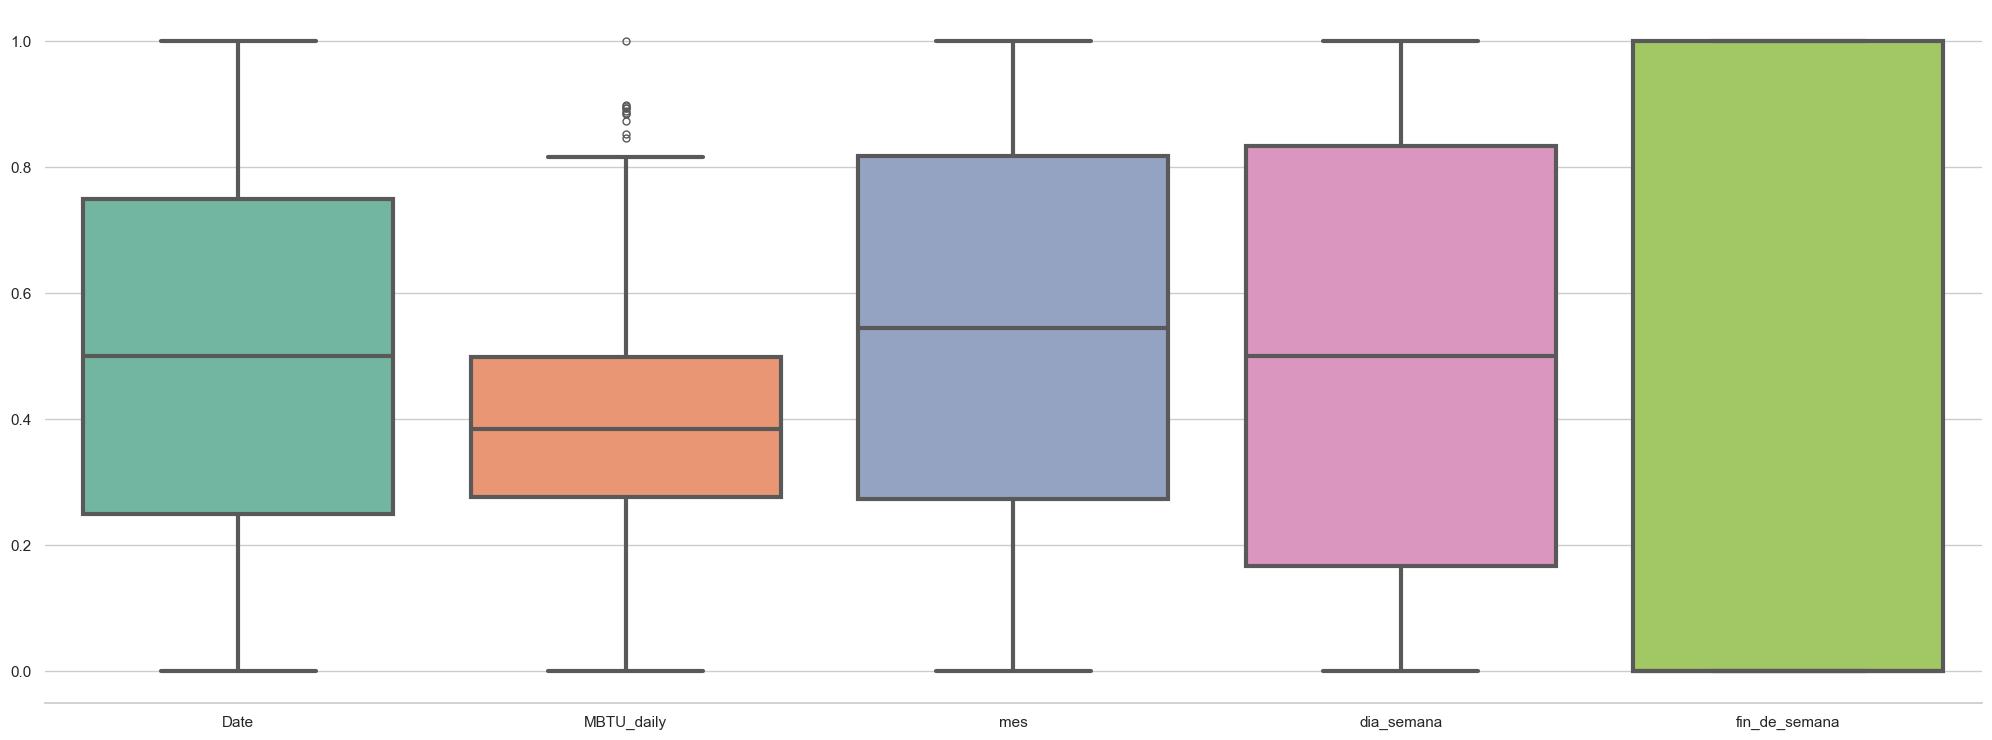

In [178]:
# Revisión de datos atipicos

df_consumo_normalizada = (df_agrupado - df_agrupado.min())/(df_agrupado.max() - df_agrupado.min())

sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.boxplot(data = df_consumo_normalizada, linewidth = 3,
            palette="Set2", fliersize = 5)
sns.despine(left=True)

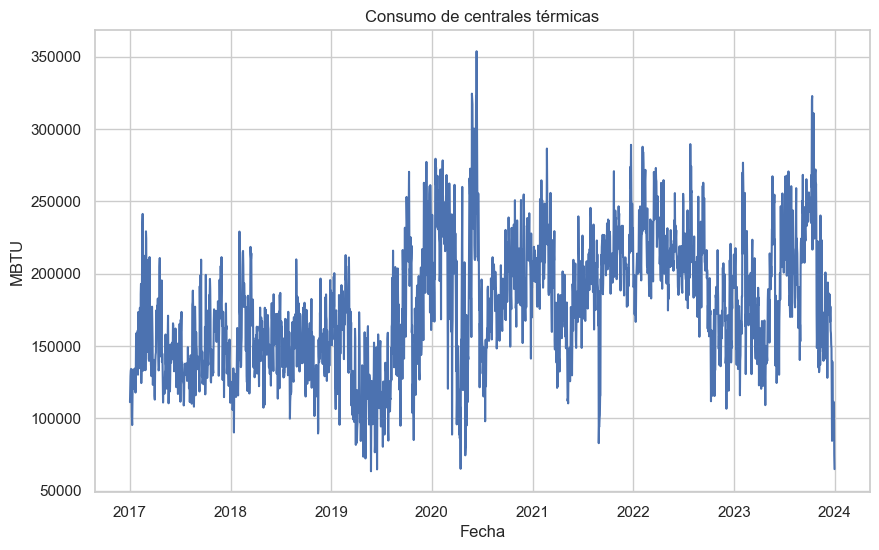

In [179]:
# Grafica exploratoria de datos apartir de una fecha inicio y fin que se encuentren en el rango inicial de descarga.
df_agrupado['Date'] = pd.to_datetime(df_agrupado['Date'])
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_agrupado[(df_agrupado['Date'] >= fecha_inicio) & (df_agrupado['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['MBTU_daily'])
plt.title('Consumo de centrales térmicas')
plt.xlabel('Fecha')
plt.ylabel('MBTU')
plt.grid(True)
plt.show()

#### **Lectura de los datos de aportes hidricos al sistema de generación hidroeléctrico.**

In [180]:
# Lectura de datos crudos de Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)
df_AportesH2O = objetoAPI.request_data("AporCaudal",
                                    "Rio",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_AportesH2O

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


,Id,Name,Value,Date
0,Rio,A. SAN LORENZO,22.080,2023-12-26
1,Rio,ALTOANCHICAYA,76.090,2023-12-26
2,Rio,AMOYA,12.820,2023-12-26
3,Rio,BATA,22.910,2023-12-26
4,Rio,BETANIA CP,158.939,2023-12-26
...,...,...,...,...
895,Rio,PRADO,117.520,2017-01-30
896,Rio,SAN CARLOS,74.133,2017-01-30
897,Rio,SINU URRA,130.620,2017-01-30
898,Rio,SOGAMOSO,178.131,2017-01-30


In [181]:
# Se agrupan los datos por fecha y se suman los valores de MBTU
df_AportesH2O = df_AportesH2O.groupby('Date')['Value'].sum().reset_index()
df_AportesH2O['Date'] = pd.to_datetime(df_AportesH2O['Date'])
df_AportesH2O

,Date,Value
0,2017-01-01,2072.490
1,2017-01-02,1872.113
2,2017-01-03,1531.154
3,2017-01-04,1468.189
4,2017-01-05,1655.904
...,...,...
2544,2023-12-27,2372.738
2545,2023-12-28,2327.821
2546,2023-12-29,2560.345
2547,2023-12-30,2452.609


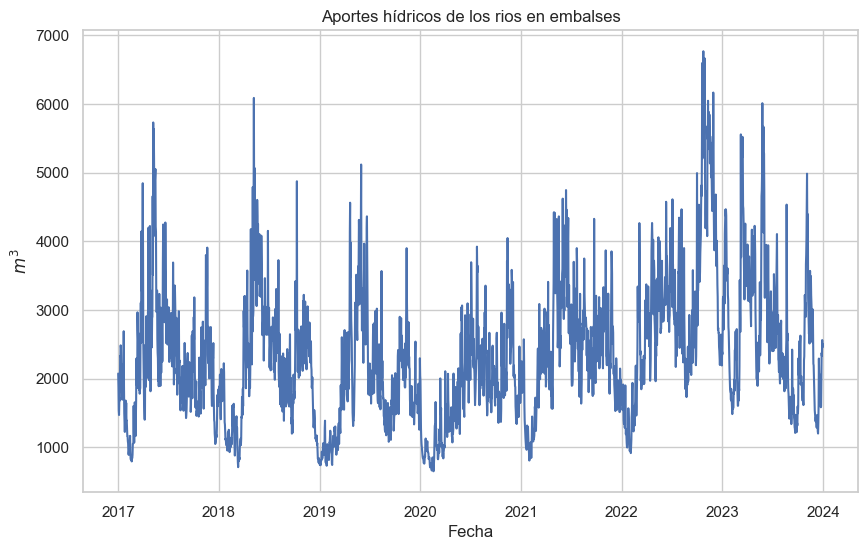

In [182]:
# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_AportesH2O[(df_AportesH2O['Date'] >= fecha_inicio) & (df_AportesH2O['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Value'])
plt.title('Aportes hídricos de los rios en embalses')
plt.xlabel('Fecha')
plt.ylabel('$m^3$')
plt.grid(True)
plt.show()

In [183]:
df_consumos = df_agrupado.merge(df_AportesH2O[['Date', 'Value']], how='left', on='Date').reset_index(drop=True)

df_consumos

,Date,MBTU_daily,mes,dia_semana,fin_de_semana,Value
0,2017-01-01,111125.1939,1,7,1,2072.490
1,2017-01-02,121709.4724,1,1,0,1872.113
2,2017-01-03,129139.7813,1,2,0,1531.154
3,2017-01-04,132915.7968,1,3,0,1468.189
4,2017-01-05,134121.5011,1,4,0,1655.904
...,...,...,...,...,...,...
2551,2023-12-27,110657.3533,12,3,0,2372.738
2552,2023-12-28,111378.0145,12,4,0,2327.821
2553,2023-12-29,109553.5381,12,5,0,2560.345
2554,2023-12-30,74725.1900,12,6,1,2452.609


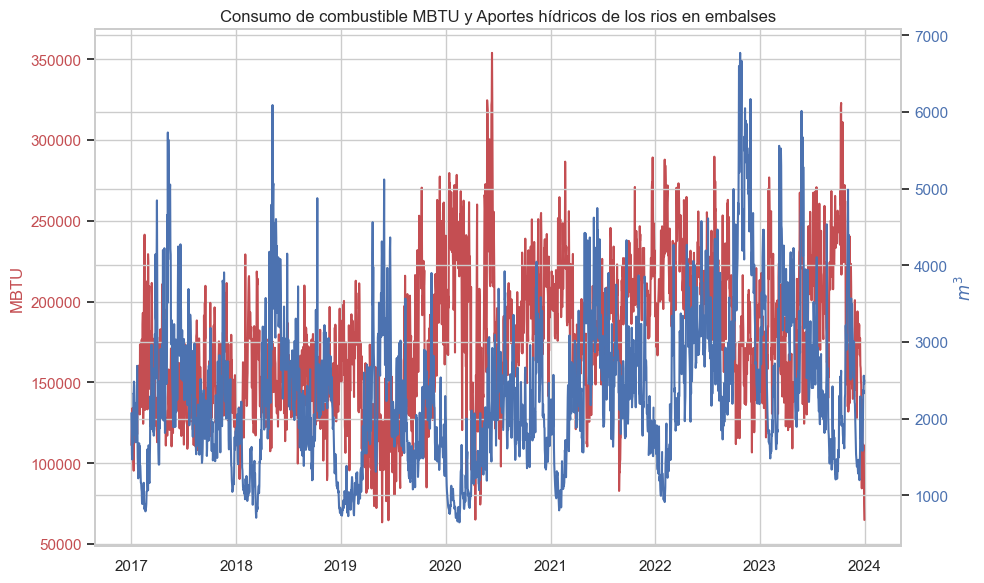

In [184]:
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos[(df_consumos['Date'] >= fecha_inicio) & (df_consumos['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Value'], color='b', label='Aportes hídricos')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$m^3$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

#### **Correlación entre el comsumo de combustible y los aportes hídricos del sistema**

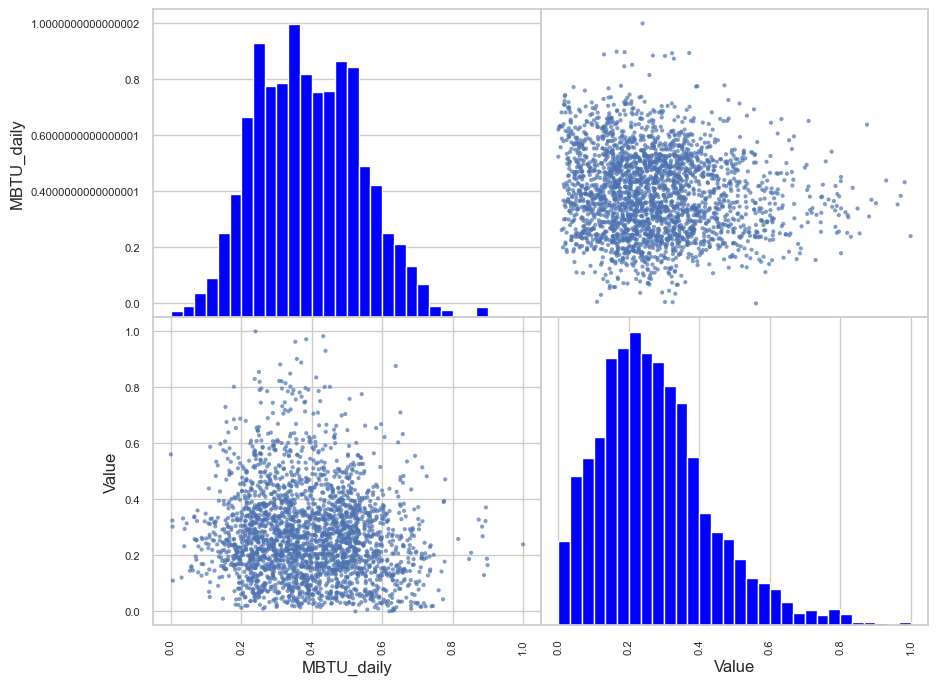

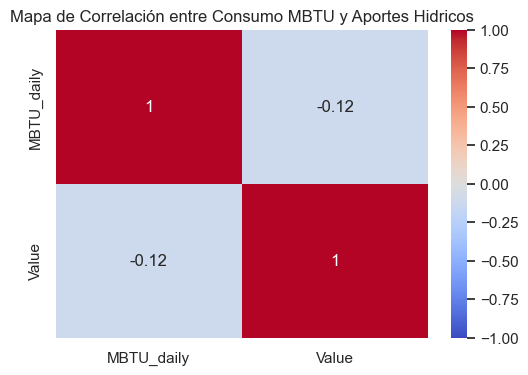

In [185]:
data_consumo_normalizada = df_consumos[['MBTU_daily', 'Value']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### **Análisis de correlación con el precio en bolsa Nacional**

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:234: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col],errors='ignore')
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\pydataxm\pydataxm.py:236: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data['Date'] = pd.to_datetime(data['Date'],errors='ignore', format= '%Y-%m-%d')


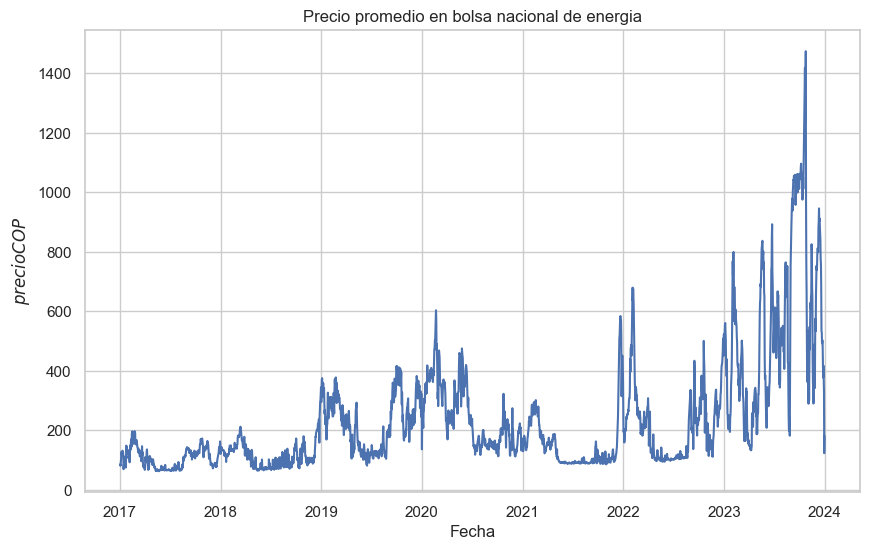

In [186]:
# Lectura de datos crudos de los precios en bolsa nacionales del SIN, en pesos COP por segundo durante el periodo 2017-2023.
# Valores de Caudal en m3/segundo.
fecha_inicio = dt.date(2017, 1, 1)
fecha_fin = dt.date(2023, 12, 31)

df_precios = objetoAPI.request_data("PrecBolsNaci",
                                    "Sistema",
                                    fecha_inicio,
                                    fecha_fin)
# tabla de datos inicial con la que se va a trabajar.
df_precios

# Los valores nulos se inicializan con cero, esto se realiza, ya que en los datos los momentos en que una central térmica no esta generando energía se muestran como Nan.
df_precios = df_precios.fillna(0)
# Se suman los valores horarios correspondientes a las 24 horas de un día para tener una variable de consumo diario.
df_precios['Precios_diarios'] = df_precios.mean(axis=1, numeric_only=True)

# Se agrupan los datos por fecha y se promedia el valor de precio en bolsa por día
df_precios = df_precios.groupby('Date')['Precios_diarios'].sum().reset_index()
df_precios['Date'] = pd.to_datetime(df_precios['Date'])

# Filtrado de datos en inicio y fin
fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_rango = df_precios[(df_precios['Date'] >= fecha_inicio) & (df_precios['Date'] <= fecha_fin)]

plt.figure(figsize=(10, 6))
plt.plot(df_rango['Date'], df_rango['Precios_diarios'])
plt.title('Precio promedio en bolsa nacional de energia')
plt.xlabel('Fecha')
plt.ylabel('$precio COP$')
plt.grid(True)
plt.show()

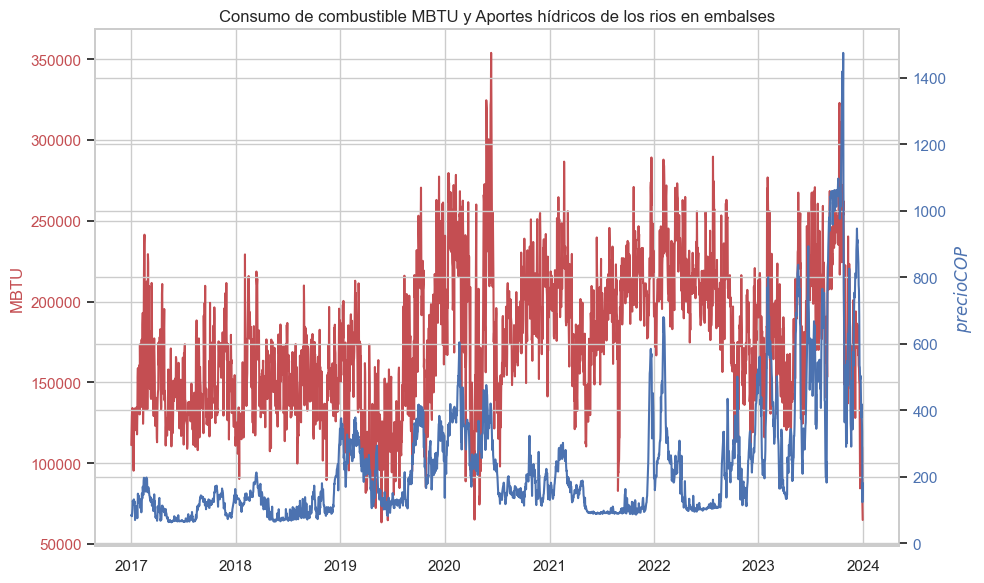

In [187]:
df_consumos_precios = df_agrupado.merge(df_precios[['Date', 'Precios_diarios']], how='left', on='Date').reset_index(drop=True)

fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio) & (df_consumos_precios['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Precios_diarios'], color='b', label='Precio en bolsa')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$precio COP$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

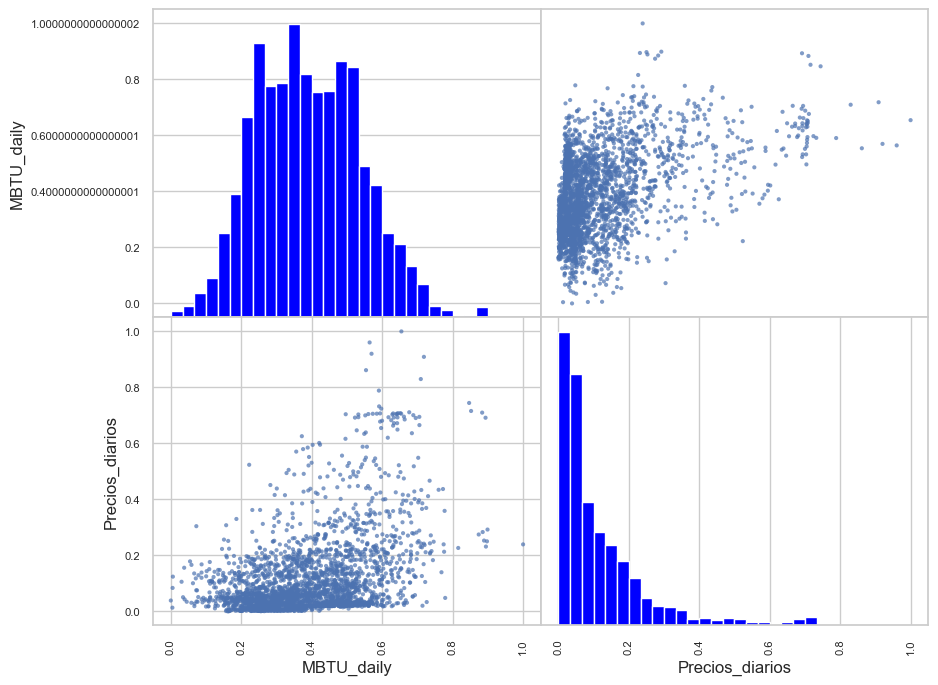

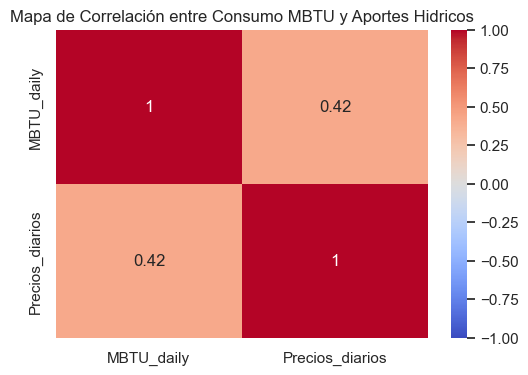

In [188]:
data_consumo_normalizada = df_consumos_precios[['MBTU_daily', 'Precios_diarios']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### Parte 3. Creación de datasets para entrenamiento y prueba de los modelos predictivos.
- Se debe considerar si es necesario excluir del estudio una epoca

**Parte 4.** Análisis exploratorio de verificaciones en serie de tiempo.

- Se realiza análisis de estacionalidad, tendencia y error de los datos.
- Se reliza test de dicked fuller.
- El análisis y pruebas se realizan en base al dataframe "df_rango" en un rango particular de datos.

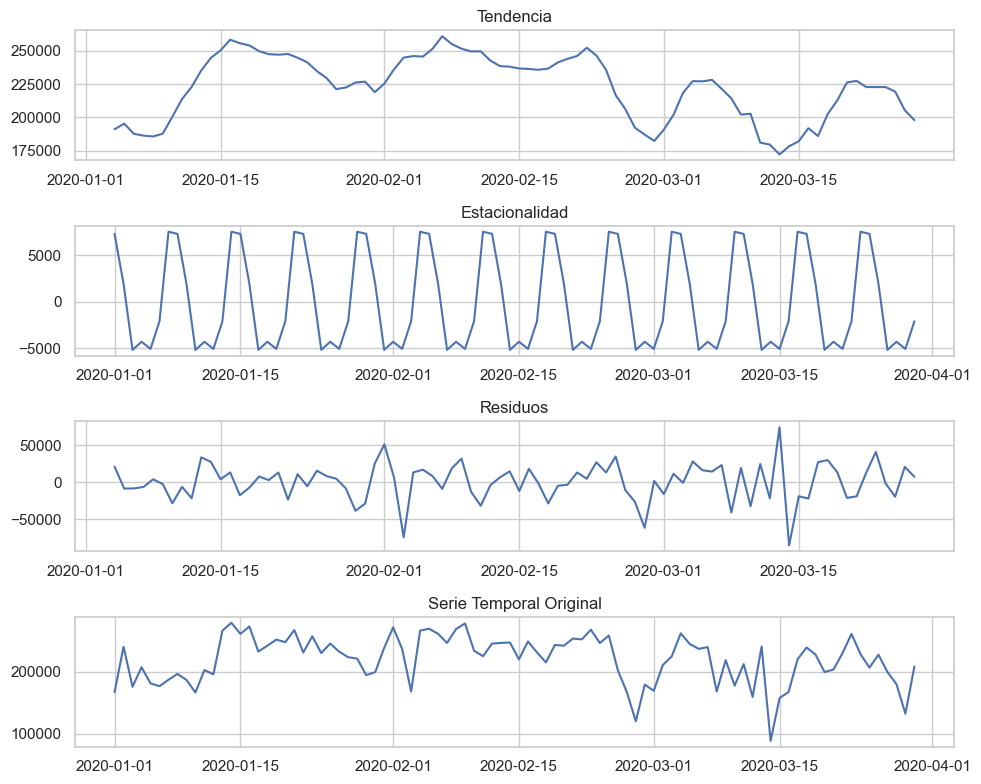

In [189]:
fecha_inicio_descom = dt.datetime.strptime("2020-1-1", "%Y-%m-%d")
fecha_fin_descom = dt.datetime.strptime("2020-3-30", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango_descom = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio_descom) & (df_consumos_precios['Date'] <= fecha_fin_descom)]

# Descomposición de series temporales
df_rango_descom.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df_rango_descom['MBTU_daily'], model='additive')
# Visualización de la descomposición
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

# Residuos
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuos')

# Serie Temporal Original
plt.subplot(414)
plt.plot(df_rango_descom['MBTU_daily'])
plt.title('Serie Temporal Original')

plt.tight_layout()
plt.show()

**Análisis resultados**
Se puede notar en la descomposición de la serie temporal se tiene una tendencia variante en el tiempo sin un patro muy claro. Una parte estacional que tiene concordancia con los datos pero de la mano con residuos de esta descomposición que tienen un comportamiento variable en los diferentes años.

In [190]:
# Test de Dicked Fuller
# Test de estacionalidad
# Aplicar el test de Dickey-Fuller
result = sm.tsa.adfuller(df_rango['MBTU_daily'])

# Mostrar los resultados del test
print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

# Interpretación de los resultados
if result[1] <= 0.05:
    print("La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).")
else:
    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula de la presencia de una raíz unitaria).")

Estadística ADF: -4.210002537144271
Valor p: 0.000633677379122661
Valores críticos: {'1%': -3.432939379929173, '5%': -2.862683979868293, '10%': -2.5673789838429837}
La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).


<Figure size 1200x600 with 0 Axes>

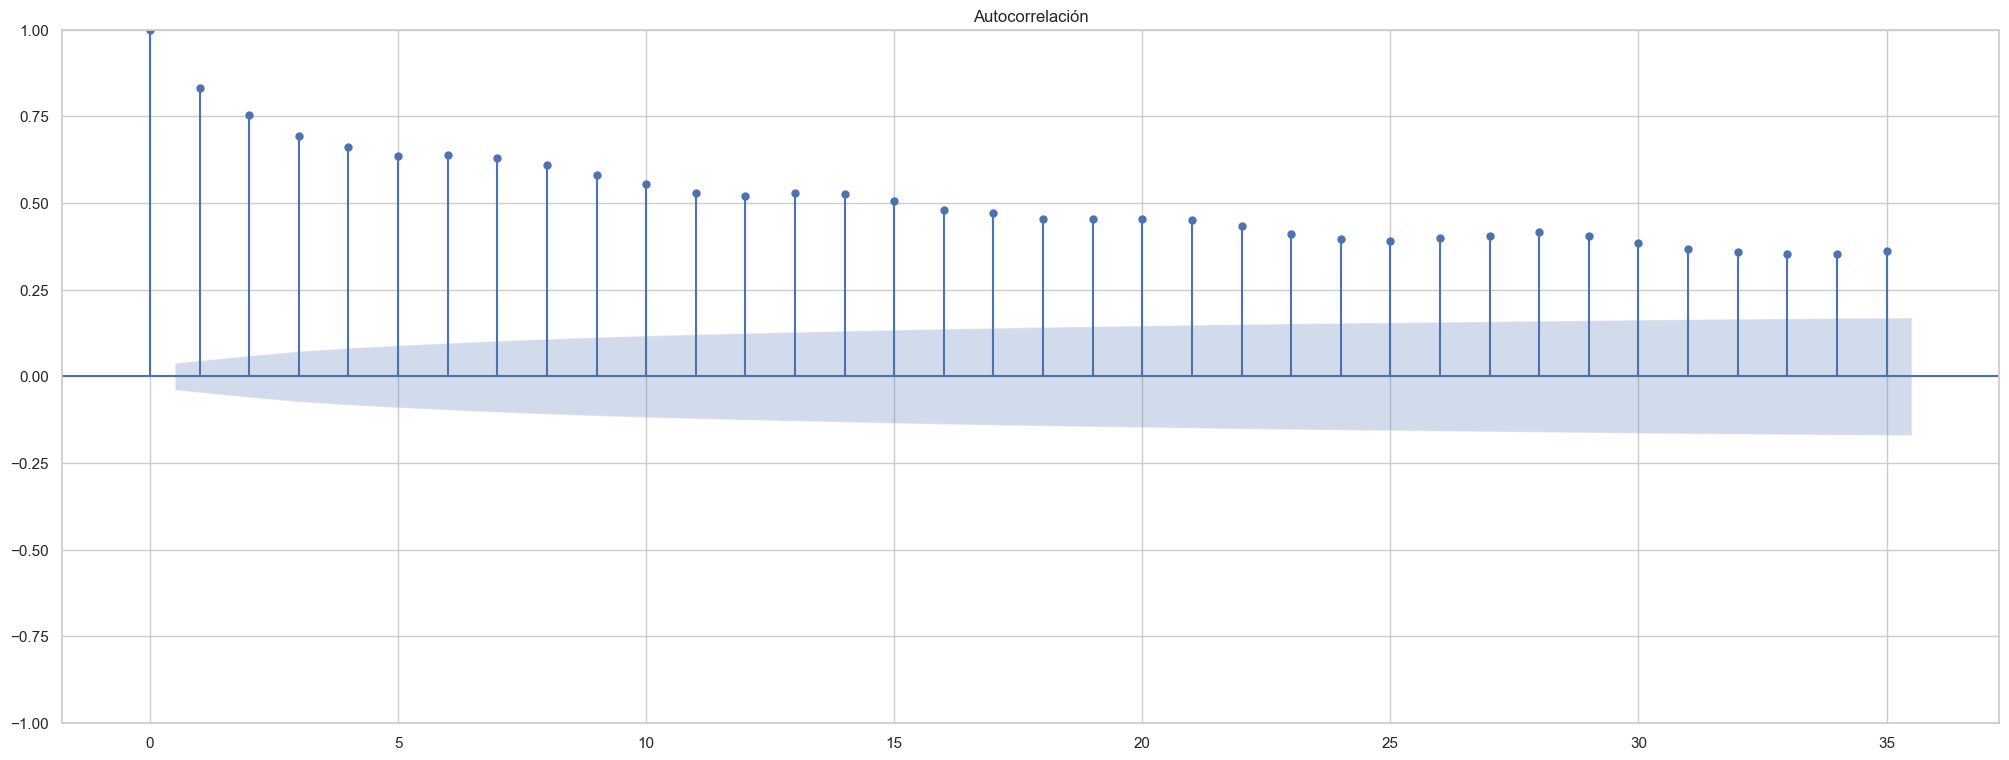

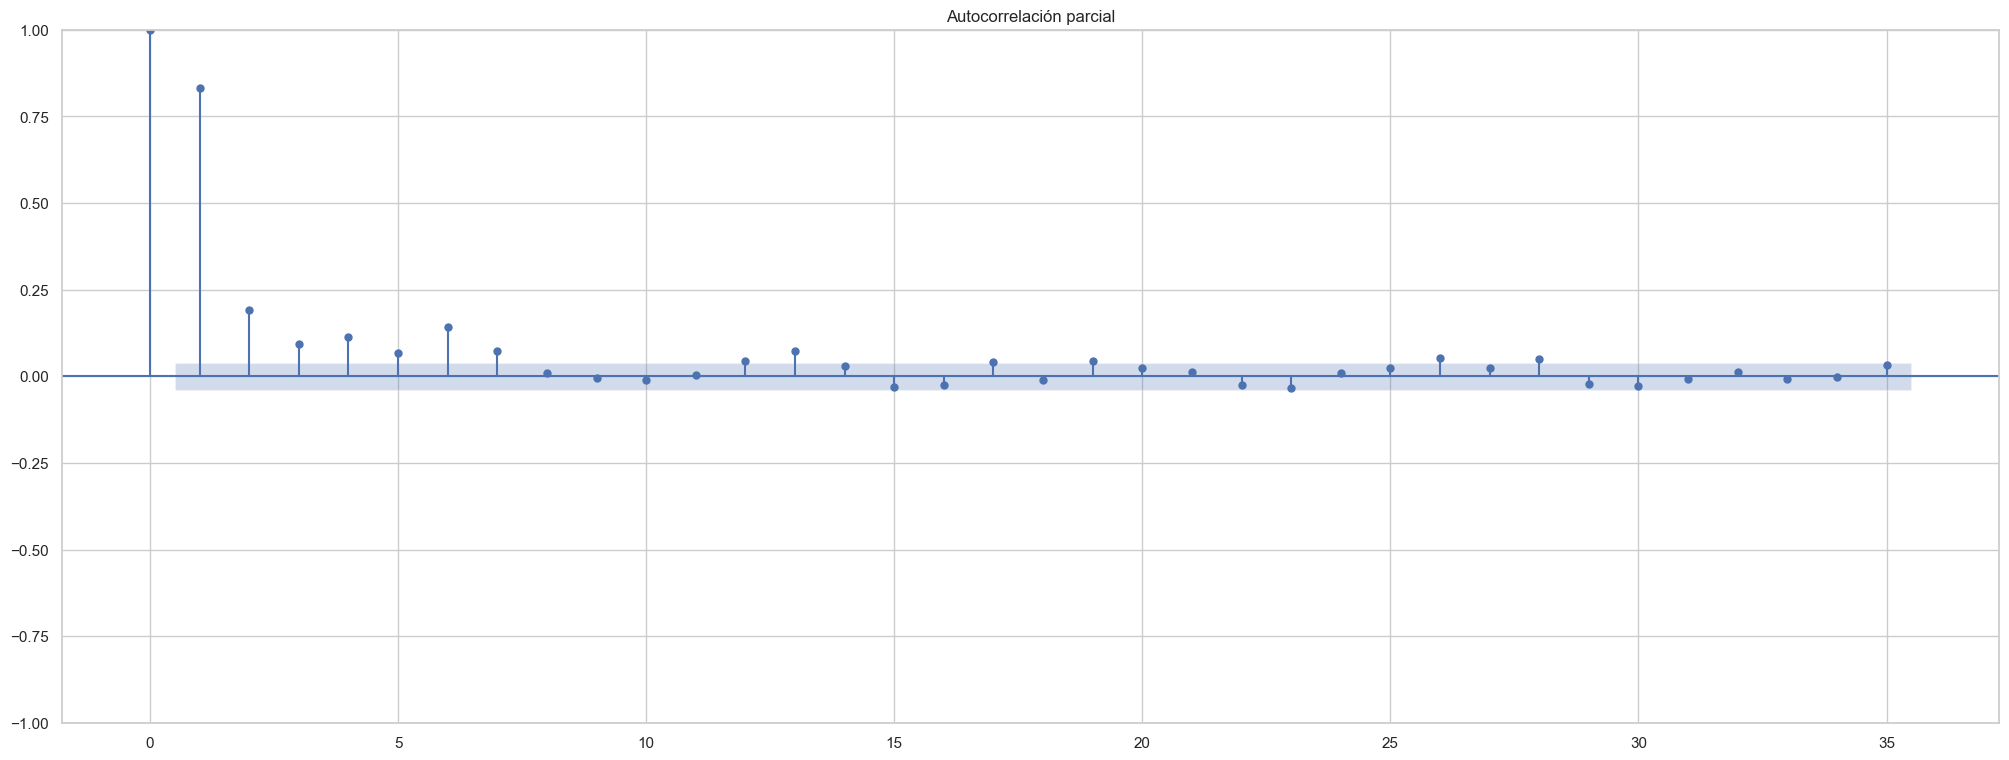

In [191]:
# Graficas ACF y PACF
plt.figure(figsize=(12, 6))

plot_acf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

In [192]:
# Guardar en csv dataframe
df_consumos_precios.to_csv('df_consumos_precios.csv', index=False)

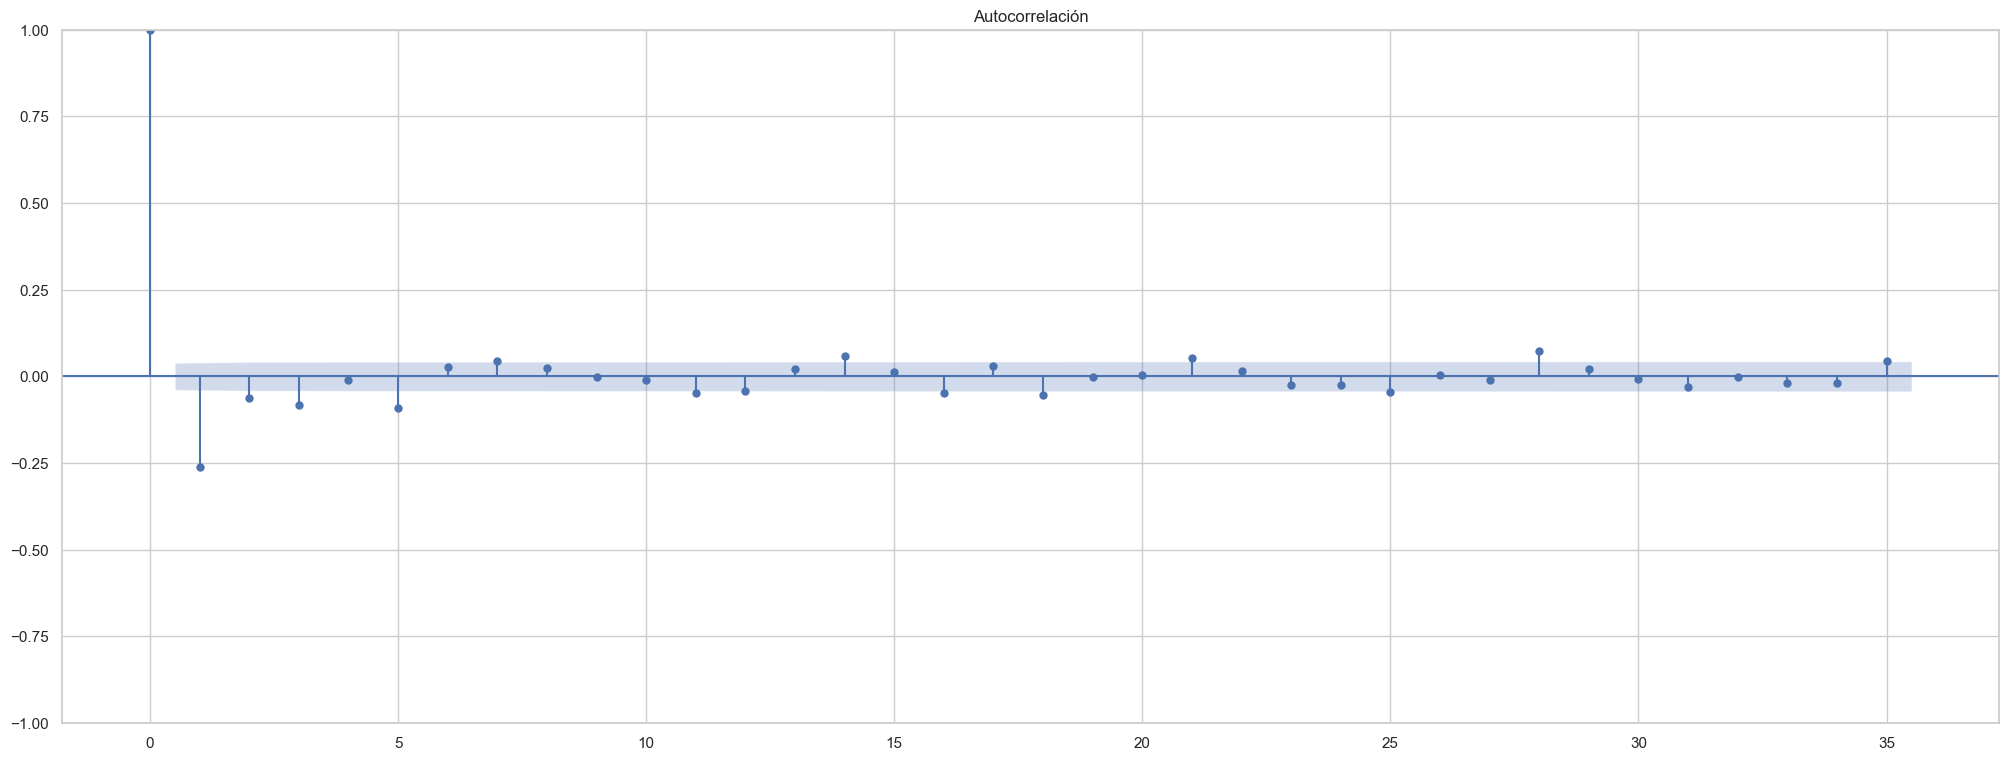

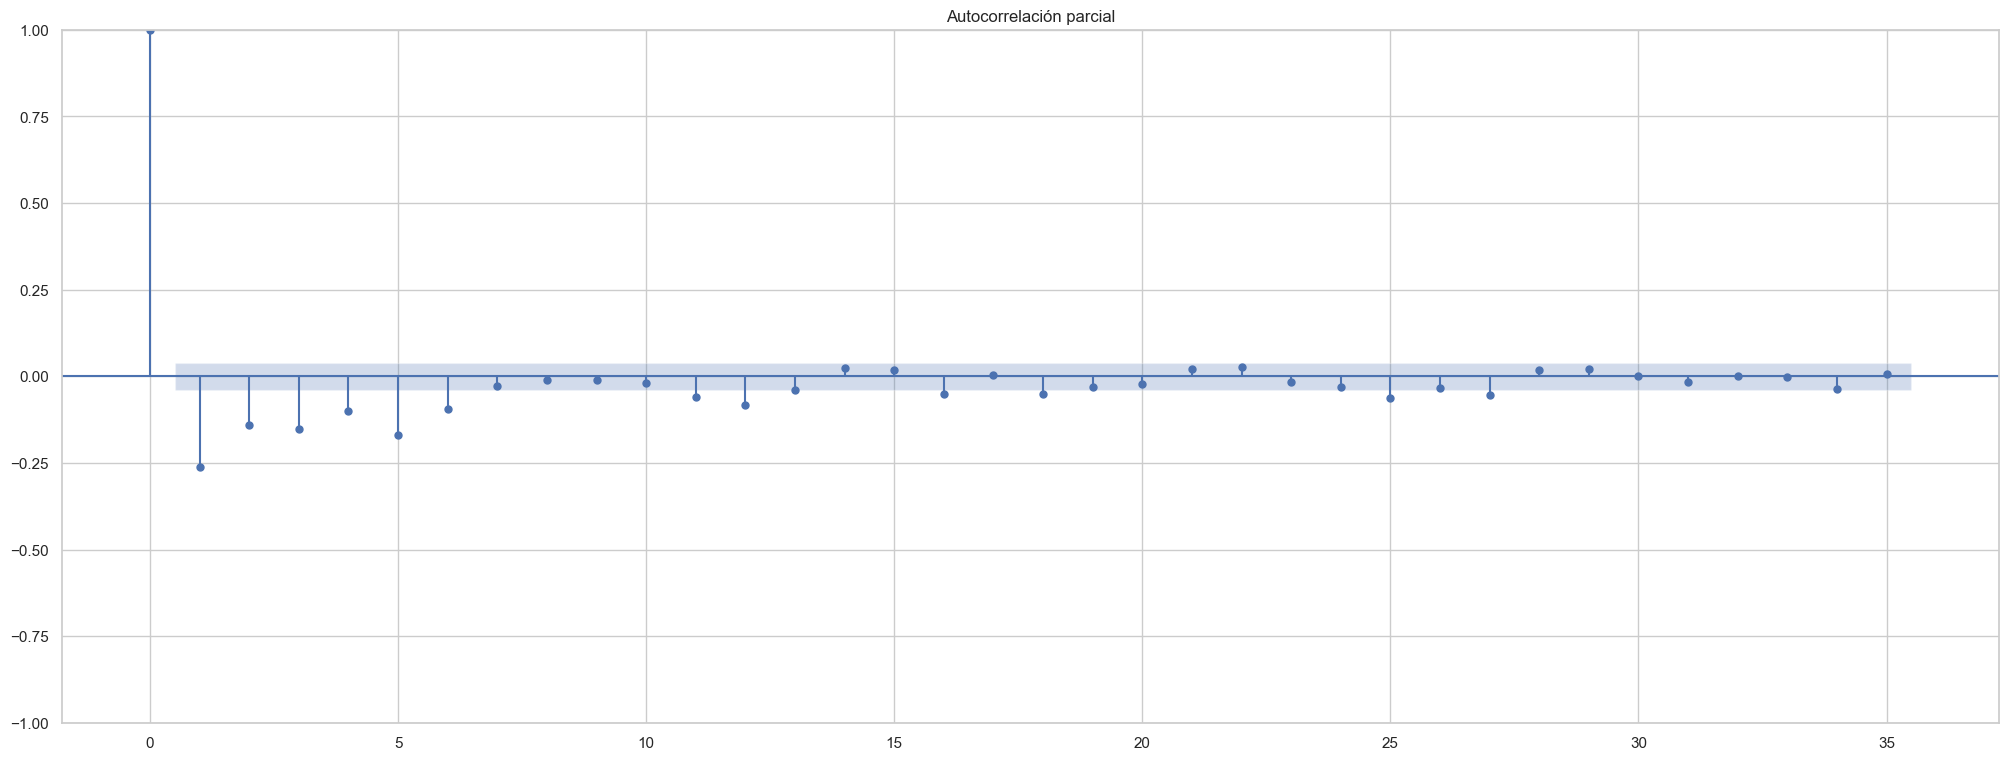

In [193]:
# Diferenciación para hacer la serie estacionaria (en caso de ser necesario)
df_consumos_precios['diferencia'] = df_consumos_precios['MBTU_daily'].diff()

plot_acf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

In [194]:
def normalize_and_split_SARIMA(df, feature_col, exog_col, train_size_ratio=0.8):
    """
    Normaliza las columnas especificadas de un DataFrame y lo divide en conjuntos de entrenamiento y prueba.

    Parámetros:
    - df: pd.DataFrame
        El DataFrame que contiene los datos a normalizar.
    - feature_col: str
        Nombre de la columna de la variable de interés (MBTU_daily).
    - exog_col: str
        Nombre de la columna de la variable exógena (Precios_diarios).
    - train_size_ratio: float
        Proporción de datos a utilizar para el conjunto de entrenamiento (por defecto es 0.8).

    Retorna:
    - train: pd.Series
        Conjunto de datos de entrenamiento para la variable de interés.
    - test: pd.Series
        Conjunto de datos de prueba para la variable de interés.
    - scaler_gas: MinMaxScaler
        Scaler utilizado para la normalización de la variable de interés.
    - scaler_precios: MinMaxScaler
        Scaler utilizado para la normalización de la variable exógena.
    """
    # Inicializar los scalers
    scaler_gas = MinMaxScaler()
    scaler_precios = MinMaxScaler()

    # Normalizar las columnas especificadas
    df_consumos_scaler = scaler_gas.fit_transform(df[[feature_col]])
    df_consumos_scaler_precios = scaler_precios.fit_transform(df[[exog_col]])

    # Convertir los arrays escalados a DataFrame
    df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns=[feature_col])
    df_consumos_scaler_precios = pd.DataFrame(df_consumos_scaler_precios, columns=[exog_col])

    # Combinar los DataFrames normalizados
    df_combined = pd.concat([df_consumos_scaler, df_consumos_scaler_precios], axis=1)

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_combined) * train_size_ratio)
    train, test = df_combined[:train_size], df_combined[train_size:]

    return train, test, scaler_gas, scaler_precios


In [195]:
def create_dataset(data, exog, time_step=1):
    """
    Crea conjuntos de datos para un modelo de series temporales a partir de un conjunto de datos y una variable exógena.

    Parámetros:
    - data: pd.DataFrame o np.ndarray
        Conjunto de datos que contiene los valores de interés (consumo).
        Se espera que los datos tengan al menos una columna.
    - exog: pd.DataFrame o np.ndarray
        Conjunto de datos que contiene la variable exógena a incluir en las entradas.
        Debe tener la misma cantidad de filas que 'data'.
    - time_step: int
        Número de pasos de tiempo a considerar para la creación de las entradas del modelo (por defecto es 1).

    Retorna:
    - X: np.ndarray
        Conjunto de datos de entrada, donde cada entrada es una secuencia de longitud `time_step`
        que incluye tanto los datos de consumo como la variable exógena.
    - y: np.ndarray
        Conjunto de datos de salida, que corresponde al valor siguiente a cada secuencia de entrada del conjunto de datos principal.
    """
    X, y = [], []  # Inicializa las listas para las entradas y salidas

    # Iterar a través de los datos para crear las secuencias
    for i in range(len(data) - time_step):
        # Extraer el consumo y la variable exógena para el paso de tiempo actual
        X.append(np.concatenate((data[i:(i + time_step)], exog[i:(i + time_step)]), axis=1))
        y.append(data[i + time_step, 0])  # Añadir el siguiente valor del conjunto de datos principal como salida

    return np.array(X), np.array(y)  # Convierte las listas a arrays de NumPy y los retorna


def normalize_and_split_LSTM(df, feature_col, exog_col, train_size_ratio=0.8):
    """
    Normaliza las columnas especificadas de un DataFrame y lo divide en conjuntos de entrenamiento y prueba.

    Parámetros:
    - df: pd.DataFrame
        El DataFrame que contiene los datos a normalizar.
    - feature_col: str
        Nombre de la columna de la variable de interés (MBTU_daily).
    - exog_col: str
        Nombre de la columna de la variable exógena (Precios_diarios).
    - train_size_ratio: float
        Proporción de datos a utilizar para el conjunto de entrenamiento (por defecto es 0.9).

    Retorna:
    - train: pd.DataFrame
        Conjunto de datos de entrenamiento.
    - test: pd.DataFrame
        Conjunto de datos de prueba.
    - scaler_consumo: MinMaxScaler
        Scaler utilizado para la normalización de la variable de interés.
    - scaler_exog: MinMaxScaler
        Scaler utilizado para la normalización de la variable exógena.
    """
    # Normalizar la variable de interés
    scaler_consumo = MinMaxScaler(feature_range=(0, 1))
    df_consumos_scaler = scaler_consumo.fit_transform(df[[feature_col]])

    # Normalizar la variable exógena
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    df_consumos_scaler_precios = scaler_exog.fit_transform(df[[exog_col]])

    # Convertir los arrays escalados a DataFrame
    df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns=[feature_col])
    df_consumos_scaler_precios = pd.DataFrame(df_consumos_scaler_precios, columns=[exog_col])

    # Combinar los DataFrames normalizados
    df_selected = pd.concat([df_consumos_scaler, df_consumos_scaler_precios], axis=1)
    # Dividir el DataFrame en conjuntos de entrenamiento y prueba

    train_size = int(len(df_selected) * train_size_ratio)
    train, test = df_selected[:train_size], df_selected[train_size:]

    return train, test, scaler_consumo, scaler_exog

def create_datasets(train, test, time_step):
    """
    Crea datasets para entrenamiento y prueba a partir de los conjuntos divididos.

    Parámetros:
    - train: pd.DataFrame
        Conjunto de datos de entrenamiento.
    - test: pd.DataFrame
        Conjunto de datos de prueba.
    - time_step: int
        Número de pasos de tiempo a utilizar en la creación de los datasets.

    Retorna:
    - X_train: np.ndarray
        Conjunto de datos de entrada para el entrenamiento.
    - y_train: np.ndarray
        Conjunto de datos de salida para el entrenamiento.
    - X_test: np.ndarray
        Conjunto de datos de entrada para la prueba.
    - y_test: np.ndarray
        Conjunto de datos de salida para la prueba.
    """

    # Crear datasets a partir de las columnas normalizadas
    X_train, y_train = create_dataset(train[['MBTU_daily']].values, train[['Precios_diarios']].values, time_step)
    X_test, y_test = create_dataset(test[['MBTU_daily']].values, test[['Precios_diarios']].values, time_step)

    # Remodelar para el formato adecuado del modelo LSTM [muestras, pasos de tiempo, características]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)  # 2 características: MBTU_daily y Precios_diarios
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

    return X_train, y_train, X_test, y_test


## **Parte 4.** Modelación con SARIMAX

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                          MBTU_daily   No. Observations:                 2044
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 7)   Log Likelihood                2361.438
Date:                           vie., 18 oct. 2024   AIC                          -4706.877
Time:                                     11:59:24   BIC                          -4661.923
Sample:                                          0   HQIC                         -4690.386
                                            - 2044                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Precios_diarios     0.9425      0.077     12.213      0.000       0.791       1.094
ar.L1       

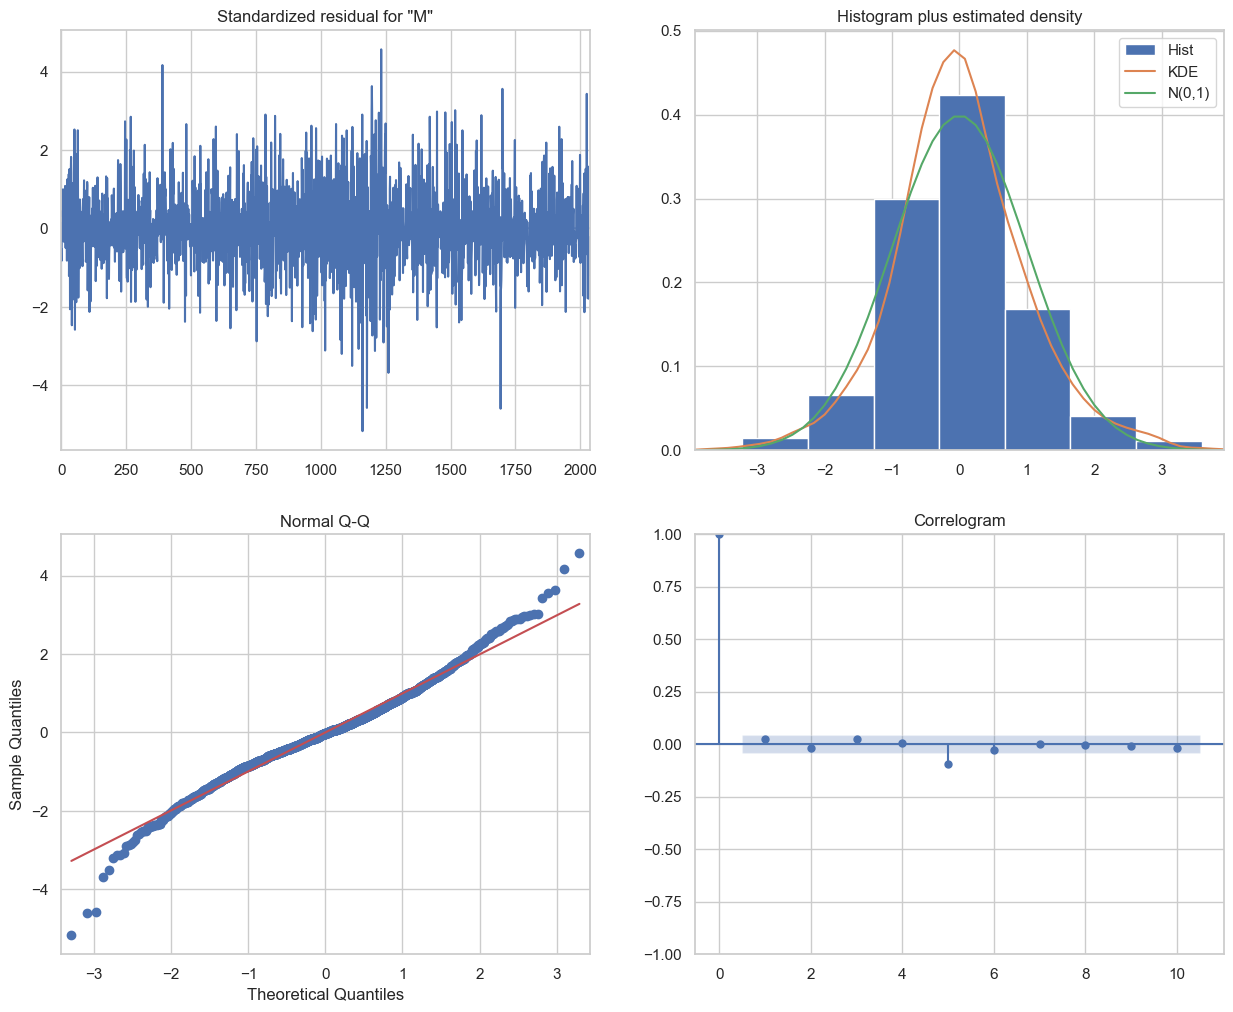

In [196]:

# Separación de datos
size_SARIMA = 0.8  # Proporción de datos para el conjunto de entrenamiento

# Normalizar y dividir los datos
train, test, scaler_gas, scaler_precios = normalize_and_split_SARIMA(df_consumos_precios, 'MBTU_daily', 'Precios_diarios',train_size_ratio = size_SARIMA)

# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Ajustar el modelo con la variable exógena
model_simple = SARIMAX(train['MBTU_daily'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s))

# Ajustar el modelo con la variable exógena
model_exog = SARIMAX(train['MBTU_daily'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=train['Precios_diarios'])

results_simple = model_simple.fit()
results = model_exog.fit()

# Resumen del modelo
print(results.summary())

# Gráficos de diagnóstico
results.plot_diagnostics(figsize=(15, 12))
plt.show()

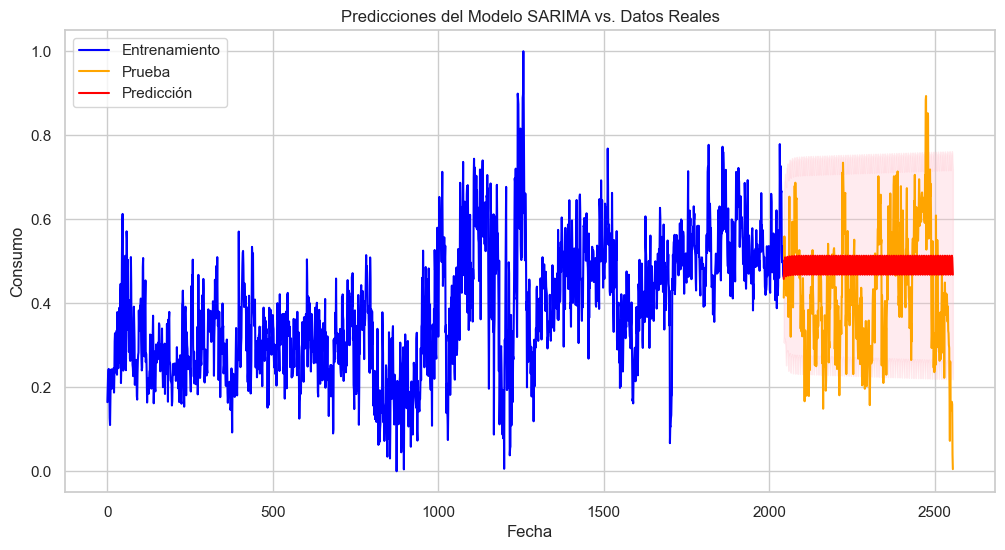

In [197]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
pred_simple = results_simple.get_forecast(steps=len(test))
pred_conf_simple = pred_simple.conf_int()

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train['MBTU_daily'], label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test['MBTU_daily'], label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred_simple.predicted_mean.index, pred_simple.predicted_mean, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf_simple.index, pred_conf_simple.iloc[:, 0], pred_conf_simple.iloc[:, 1], color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMA vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

Raíz del Error Cuadrático Medio (RMSE): 0.41
Error Absoluto Medio (MAE): 0.37
Error Porcentual Absoluto Medio (MAPE): 128.01%


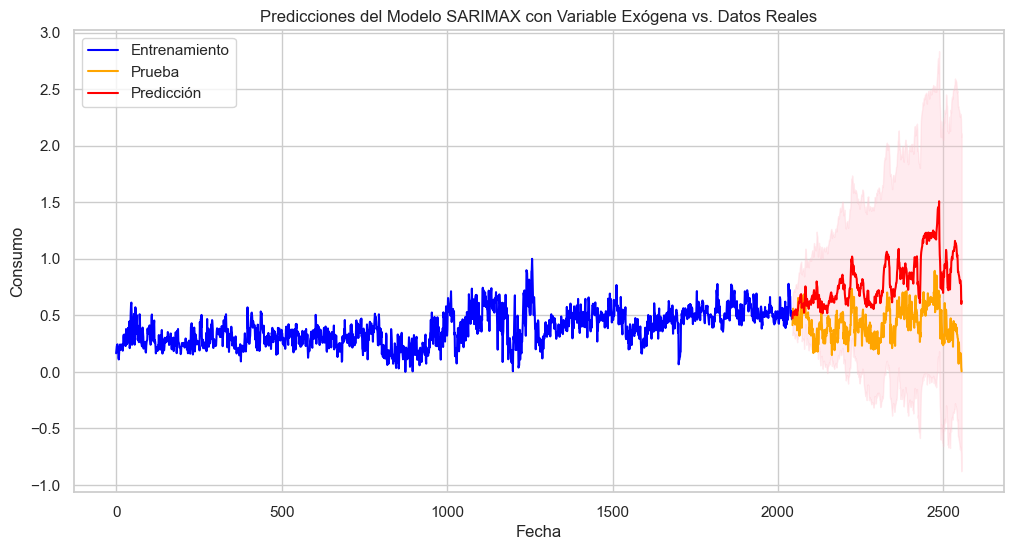

In [198]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
pred = results.get_forecast(steps=len(test), exog=test['Precios_diarios'])
pred_conf = pred.conf_int()

# Evaluación del modelo.

# Predicciones y valores reales
predicciones = pred.predicted_mean
valores_reales = test['MBTU_daily']

# Calcular las métricas
rmse = np.sqrt(np.mean((predicciones - valores_reales) ** 2))
mae = np.mean(np.abs(predicciones - valores_reales))
mape = np.mean(np.abs((predicciones - valores_reales) / valores_reales)) * 100

# Mostrar las métricas
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train['MBTU_daily'], label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test['MBTU_daily'], label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMAX con Variable Exógena vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

## **Parte 5.** Modelación con Red Neural LSTM

In [199]:
#Separación de datos
time_step = 7  # Define el paso de tiempo que usarás en el modelo
size = 0.8  # Proporción de datos para el conjunto de entrenamiento

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size)
# Crear los datasets para el modelo
X_train, y_train, X_test, y_test = create_datasets(train_LSTM, test_LSTM, time_step)

In [200]:
# Seleccionas la primera columna de la última dimensión, no incluir la variable exogena.
X_train_mbtu = X_train[:, :, 0]
X_test_mbtu = X_test[:, :, 0]

model_LSTM_ini = Sequential()
model_LSTM_ini.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_LSTM_ini.add(Dropout(0.2))
model_LSTM_ini.add(LSTM(50, return_sequences=False))
model_LSTM_ini.add(Dropout(0.2))
model_LSTM_ini.add(Dense(1)) # predicción de un valor

model_LSTM_ini.compile(optimizer='adam', loss='mean_squared_error')

historia_LSTM_ini = model_LSTM_ini.fit(X_train_mbtu, y_train, epochs=20, batch_size=32)

# Hacer predicciones
train_predict_LSTM_ini = model_LSTM_ini.predict(X_train_mbtu)
test_predict_LSTM_ini = model_LSTM_ini.predict(X_test_mbtu)

# # Obtener los valores reales
# y_train_inv = y_train.reshape(-1, 1)
# y_test_inv = y_test.reshape(-1, 1)

# # Invertir la normalización
# train_predict = scaler_consumo.inverse_transform(train_predict)
# test_predict = scaler_consumo.inverse_transform(test_predict)

# # Obtener los valores reales
# y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
# y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/20


c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0383
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 16/20
64/64 ━━━━━━━━━━━━

Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.06
Error Porcentual Absoluto Medio (MAPE): 22.29%


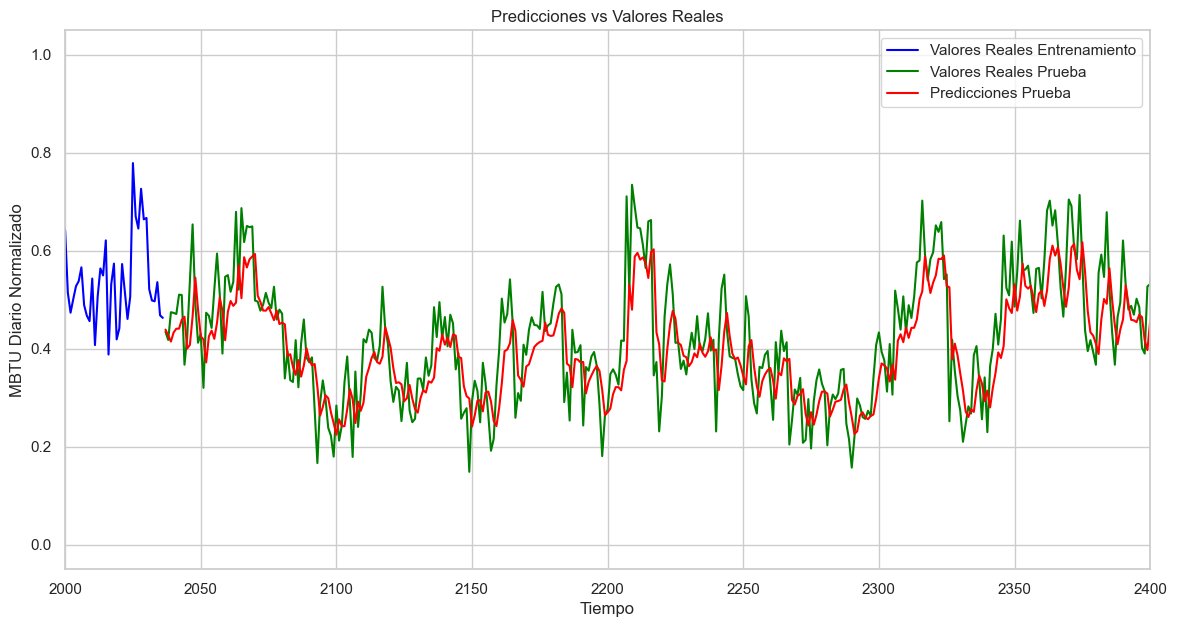

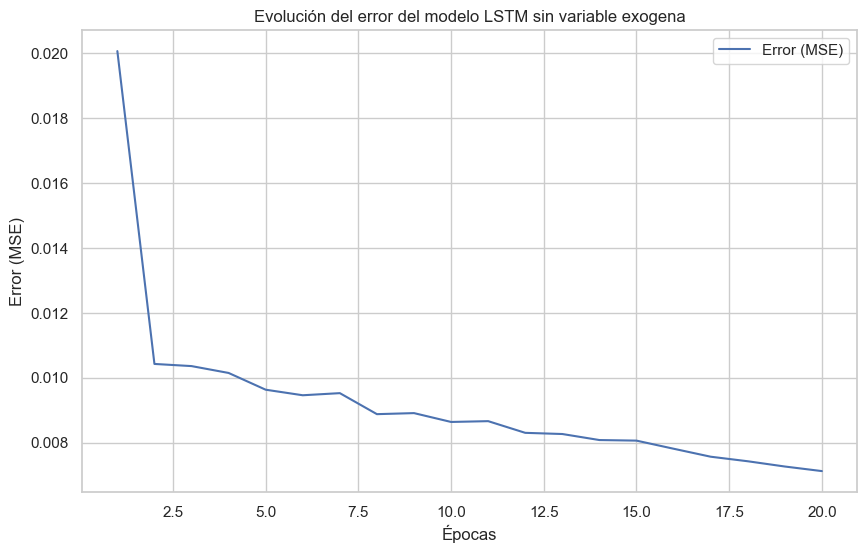

In [201]:
# Métricas de evaluación
rmse = np.sqrt(np.mean((test_predict_LSTM_ini.flatten() - y_test.flatten()) ** 2))
mae = np.mean(np.abs(test_predict_LSTM_ini.flatten() - y_test.flatten()))
mape = np.mean(np.abs((test_predict_LSTM_ini.flatten() - y_test.flatten()) / y_test.flatten())) * 100

print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Crear un rango de tiempo para las gráficas
train_len = len(y_train)
test_len = len(y_test)
total_len = train_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train, y_test), axis=0)

# Gráfico
plt.figure(figsize=(14, 7))

# Graficar los datos reales
plt.plot(time[:train_len], y_train, label='Valores Reales Entrenamiento', color='blue')
plt.plot(time[train_len:], y_test, label='Valores Reales Prueba', color='green')

# Graficar las predicciones
#plt.plot(time[:train_len], train_predict_inv, label='Predicciones Entrenamiento', color='orange')
plt.plot(time[train_len:], test_predict_LSTM_ini, label='Predicciones Prueba', color='red')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario Normalizado')
plt.legend()

# Establecer límites de los ejes
plt.xlim(2000,2400)  # Ajusta el rango del eje X
#plt.ylim(lower_limit, upper_limit)  # Ajusta el rango del eje Y

plt.show()


# prompt: Graficar evolución de error del modelo GRU empleado en función de las epocas
loss_values = historia_LSTM_ini.history['loss']

# Create a plot of the error evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Error (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Error (MSE)')
plt.title('Evolución del error del modelo LSTM sin variable exogena')
plt.legend()
plt.show()

In [202]:
# Construir el modelo LSTM
model_LSTM_exog = Sequential()
model_LSTM_exog.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 2)))  # Cambiar a 2 para incluir la exógena
model_LSTM_exog.add(Dropout(0.2))
model_LSTM_exog.add(LSTM(units=50, return_sequences=False))
model_LSTM_exog.add(Dropout(0.2))
model_LSTM_exog.add(Dense(units=1))  # Predicción de un valor

# Compilar el modelo
model_LSTM_exog.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_LSTM_exog.fit(X_train, y_train, epochs=20, batch_size=32)

# Hacer predicciones
train_predict = model_LSTM_exog.predict(X_train)
test_predict = model_LSTM_exog.predict(X_test)

# # Invertir la normalización
# train_predict = scaler_consumo.inverse_transform(train_predict)
# test_predict = scaler_consumo.inverse_transform(test_predict)

# # Obtener los valores reales
# y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
# y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0486
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076
Epoch 16/20
64/64 ━

Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.06
Error Porcentual Absoluto Medio (MAPE): 22.97%


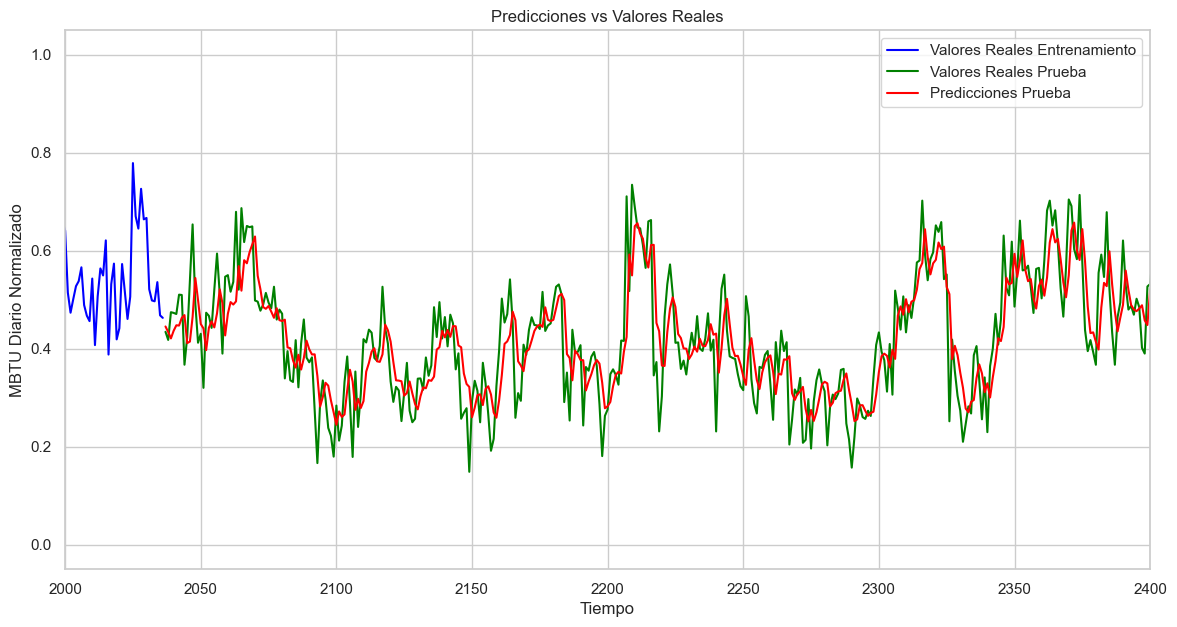

In [203]:
rmse = np.sqrt(np.mean((test_predict.flatten() - y_test.flatten()) ** 2))
mae = np.mean(np.abs(test_predict.flatten() - y_test.flatten()))
mape = np.mean(np.abs((test_predict.flatten() - y_test.flatten()) / y_test.flatten())) * 100

print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Crear un rango de tiempo para las gráficas
train_len = len(y_train)
test_len = len(y_test)
total_len = train_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train, y_test), axis=0)

# Gráfico
plt.figure(figsize=(14, 7))

# Graficar los datos reales
plt.plot(time[:train_len], y_train, label='Valores Reales Entrenamiento', color='blue')
plt.plot(time[train_len:], y_test, label='Valores Reales Prueba', color='green')

# Graficar las predicciones
#plt.plot(time[:train_len], train_predict_inv, label='Predicciones Entrenamiento', color='orange')
plt.plot(time[train_len:], test_predict, label='Predicciones Prueba', color='red')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario Normalizado')
plt.legend()

# Establecer límites de los ejes
plt.xlim(2000, 2400)  # Ajusta el rango del eje X
#plt.ylim(lower_limit, upper_limit)  # Ajusta el rango del eje Y

plt.show()



## **Parte 5.** Modelación con Red Neural GRU con y sin variable exogena.

In [204]:
# Seleccionas la primera columna de la última dimensión, no incluir la variable exogena.
X_train_mbtu = X_train[:, :, 0]
X_test_mbtu = X_test[:, :, 0]

# Construir el modelo GRU
model_GRU_ini = Sequential()
model_GRU_ini.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # 1 característica
model_GRU_ini.add(Dropout(0.2))
model_GRU_ini.add(GRU(units=50, return_sequences=False))
model_GRU_ini.add(Dropout(0.2))
model_GRU_ini.add(Dense(units=1))  # Predicción de un valor

# Compilar el modelo
model_GRU_ini.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_ini = model_GRU_ini.fit(X_train_mbtu, y_train, epochs=20, batch_size=32)

# Hacer predicciones
train_predict_GRU_ini = model_GRU_ini.predict(X_train_mbtu)
test_predict_GRU_ini = model_GRU_ini.predict(X_test_mbtu)

# # Invertir la normalización
# train_predict = scaler_consumo.inverse_transform(train_predict)
# test_predict = scaler_consumo.inverse_transform(test_predict)

# # Obtener los valores reales
# y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
# y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0447
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 16/20
64/64 ━

Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.06
Error Porcentual Absoluto Medio (MAPE): 21.13%


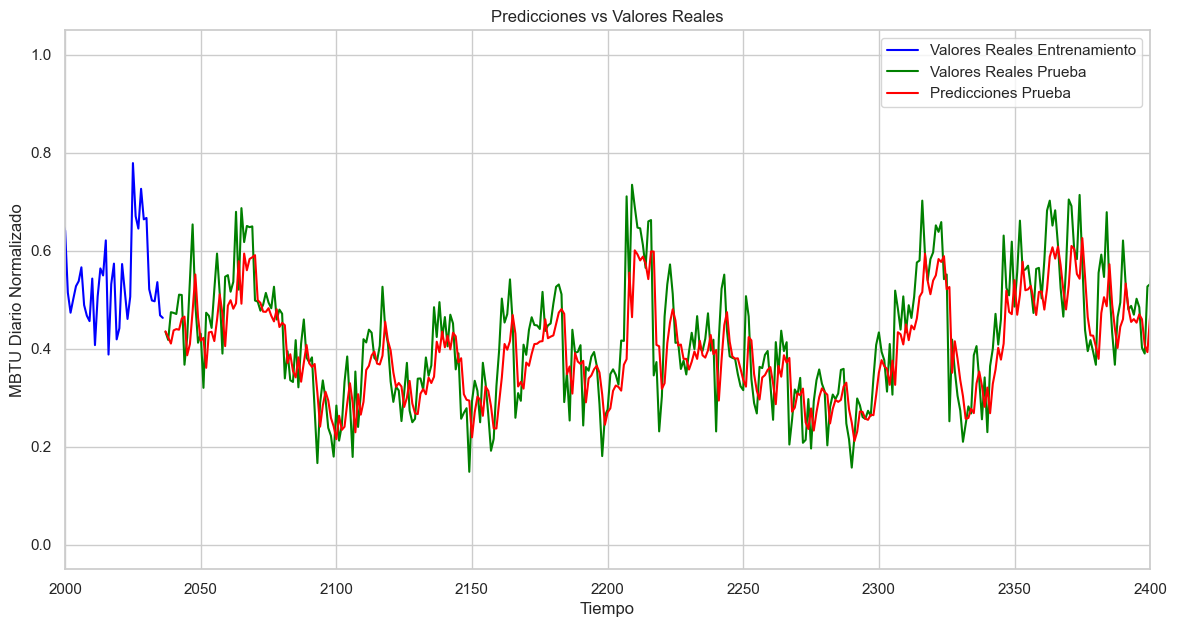

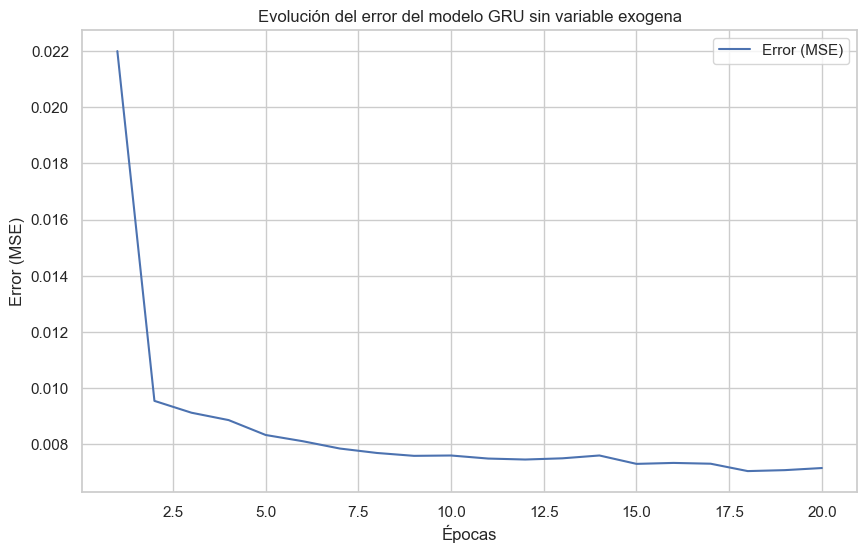

In [205]:
# Calcular métricas de evaluación
rmse = np.sqrt(np.mean((test_predict_GRU_ini.flatten() - y_test.flatten()) ** 2))
mae = np.mean(np.abs(test_predict_GRU_ini.flatten() - y_test.flatten()))
mape = np.mean(np.abs((test_predict_GRU_ini.flatten() - y_test.flatten()) / y_test.flatten())) * 100

# Mostrar las métricas
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Crear un rango de tiempo para las gráficas
train_len = len(y_train)
test_len = len(y_test)
total_len = train_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train, y_test), axis=0)

# Gráfico
plt.figure(figsize=(14, 7))

# Graficar los datos reales
plt.plot(time[:train_len], y_train, label='Valores Reales Entrenamiento', color='blue')
plt.plot(time[train_len:], y_test, label='Valores Reales Prueba', color='green')

# Graficar las predicciones
#plt.plot(time[:train_len], train_predict_inv, label='Predicciones Entrenamiento', color='orange')
plt.plot(time[train_len:], test_predict_GRU_ini, label='Predicciones Prueba', color='red')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario Normalizado')
plt.legend()

# Establecer límites de los ejes
plt.xlim(2000, 2400)  # Ajusta el rango del eje X
#plt.ylim(lower_limit, upper_limit)  # Ajusta el rango del eje Y

plt.show()


# Access the loss values from the history object
loss_values = historia_GRU_ini.history['loss']

# Create a plot of the error evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Error (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Error (MSE)')
plt.title('Evolución del error del modelo GRU sin variable exogena')
plt.legend()
plt.show()

In [206]:
# Construir el modelo GRU con variable exogena
model_GRU_exog = Sequential()
model_GRU_exog.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))  # 2 características, inclusión de la variable exógena.
model_GRU_exog.add(Dropout(0.2))
model_GRU_exog.add(GRU(units=50, return_sequences=False))
model_GRU_exog.add(Dropout(0.2))
model_GRU_exog.add(Dense(units=1))  # Predicción de un valor

# Compilar el modelo
model_GRU_exog.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_GRU_exog.fit(X_train, y_train, epochs=20, batch_size=32)

# Hacer predicciones
train_predict_GRU_exog = model_GRU_exog.predict(X_train)
test_predict_GRU_exog = model_GRU_exog.predict(X_test)

# # Invertir la normalización
# train_predict = scaler_consumo.inverse_transform(train_predict)
# test_predict = scaler_consumo.inverse_transform(test_predict)

# # Obtener los valores reales
# y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
# y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0520
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068
Epoch 16/20
64/64 

Raíz del Error Cuadrático Medio (RMSE): 0.08
Error Absoluto Medio (MAE): 0.06
Error Porcentual Absoluto Medio (MAPE): 19.21%


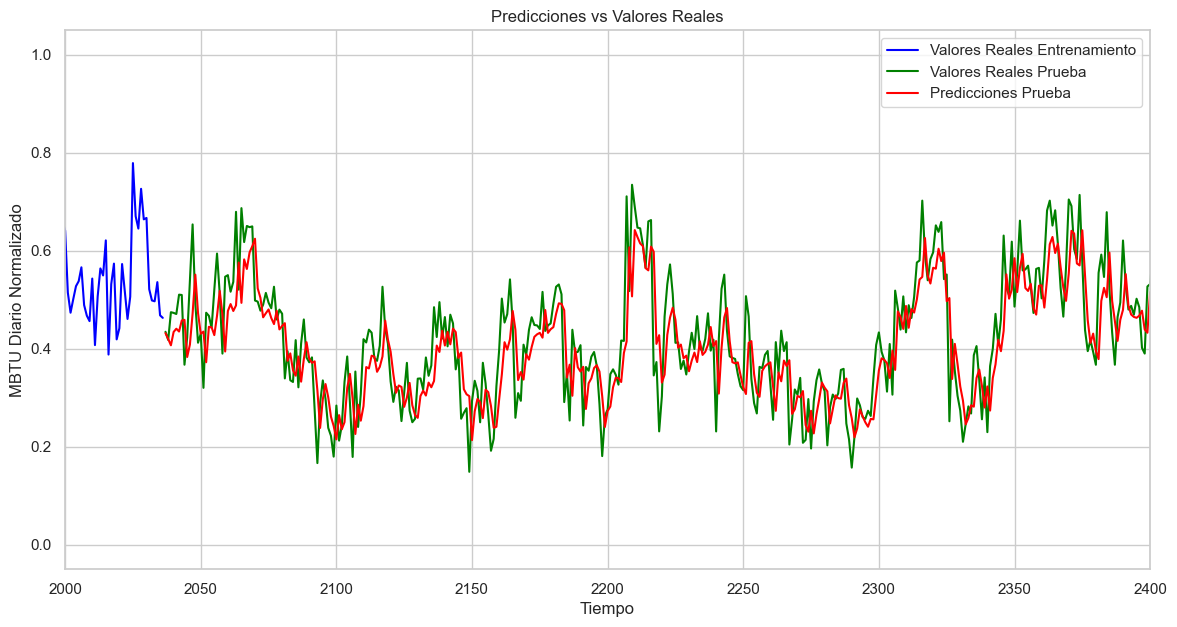

In [207]:
# Calcular métricas de evaluación
rmse = np.sqrt(np.mean((test_predict_GRU_exog.flatten() - y_test.flatten()) ** 2))
mae = np.mean(np.abs(test_predict_GRU_exog.flatten() - y_test.flatten()))
mape = np.mean(np.abs((test_predict_GRU_exog.flatten() - y_test.flatten()) / y_test.flatten())) * 100

# Mostrar las métricas
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Crear un rango de tiempo para las gráficas
train_len = len(y_train)
test_len = len(y_test)
total_len = train_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train, y_test), axis=0)

# Gráfico
plt.figure(figsize=(14, 7))

# Graficar los datos reales
plt.plot(time[:train_len], y_train, label='Valores Reales Entrenamiento', color='blue')
plt.plot(time[train_len:], y_test, label='Valores Reales Prueba', color='green')

# Graficar las predicciones
#plt.plot(time[:train_len], train_predict_inv, label='Predicciones Entrenamiento', color='orange')
plt.plot(time[train_len:], test_predict_GRU_exog, label='Predicciones Prueba', color='red')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario Normalizado')
plt.legend()

# Establecer límites de los ejes
plt.xlim(2000, 2400)  # Ajusta el rango del eje X
#plt.ylim(lower_limit, upper_limit)  # Ajusta el rango del eje Y

plt.show()

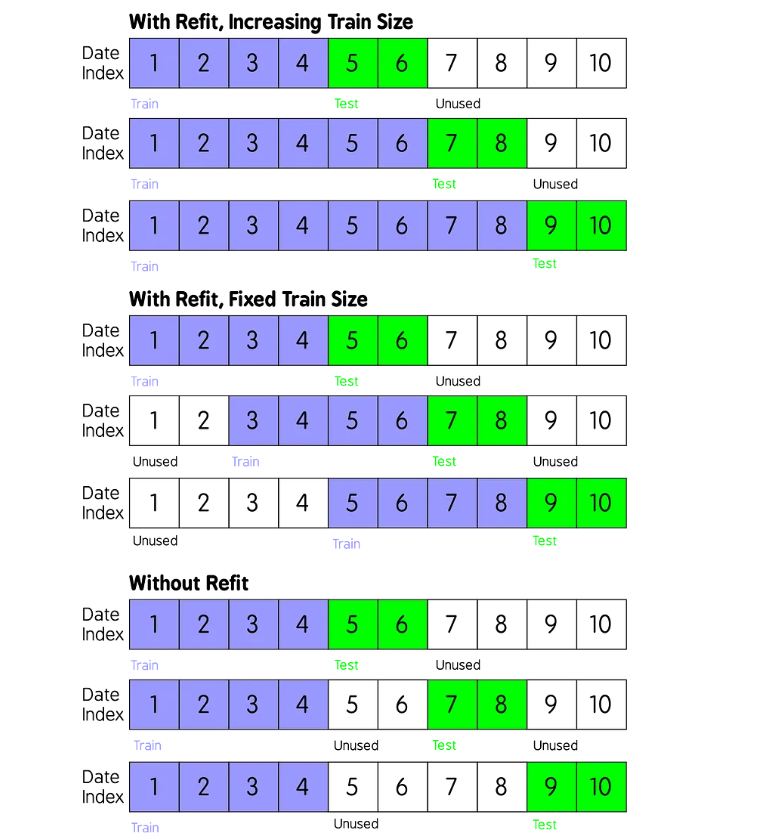

## BackTesting validación cruzada de los modelos.

In [214]:
def backtesting_with_refit_increasing_train(model, X_train_data, X_test_data, y_train_data, y_test_data, time_step):
    predictions = []
    MAPE = []
    # actuals = []

    model.fit(X_train_data, y_train_data, epochs=15, verbose=0, batch_size=32)  # Ajusta los epochs y verbose según sea necesario
    X_input = X_test_data[0:time_step]  
    # Hacer la predicción
    pred1 = model.predict(X_input)
    mape1 = np.mean(np.abs((pred1.flatten() - y_test[0:time_step].flatten()) / y_test[0:time_step].flatten())) * 100
    # Guardar la predicción y el valor real
    predictions.append(pred1[0, 0])
    MAPE.append(mape1)

    # Bucle de backtesting
    for i in range(0, len(X_test_data), time_step):
        # Crear ventanas de entrenamiento que comienzan desde el principio
        X_train = []
        y_train = []

        # Recorrer desde el inicio hasta el índice actual para aumentar el conjunto de entrenamiento
        if i + 2*time_step <= len(X_test_data):
            X_train = np.append(X_train_data, X_test_data[0:i + time_step]).reshape(X_train_data.shape[0]+(i+time_step), X_train_data.shape[1])
            y_train = np.append(y_train_data, y_test_data[0:i + time_step])
            # Obtener la ventana de prueba para predecir
            X_input = X_test_data[i + time_step:i + 2*time_step]  
            # Reajustar el modelo con el conjunto de entrenamiento actualizado
            model.fit(X_train, y_train, epochs=15, verbose=0, batch_size=32)  # Ajusta los epochs y verbose según sea necesario
            # Hacer la predicción
            pred = model.predict(X_input)
            mape = np.mean(np.abs((pred.flatten() - y_test[i + time_step:i + 2*time_step].flatten()) / y_test[i + time_step:i + 2*time_step].flatten())) * 100
            # Guardar la predicción y el valor real
            predictions.extend(pred.flatten())
            MAPE.append(mape)
        # else:
        #     X_train = np.append(X_train_data, X_test_data[0:len(X_test_data)]).reshape(X_train_data.shape[0]+(i+time_step), X_train_data.shape[1])
        #     y_train = np.append(y_train_data, y_test_data[0:len(X_test_data)])
        #     # Obtener la ventana de prueba para predecir
        #     X_input = X_test_data[i:]  
        #actuals.append(data[i + time_step])

    return np.array(predictions), np.array(MAPE) #, np.array(actuals)

predictions, MAPE = backtesting_with_refit_increasing_train(model_LSTM_ini, X_train_mbtu, X_test_mbtu, y_train, y_test, time_step)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

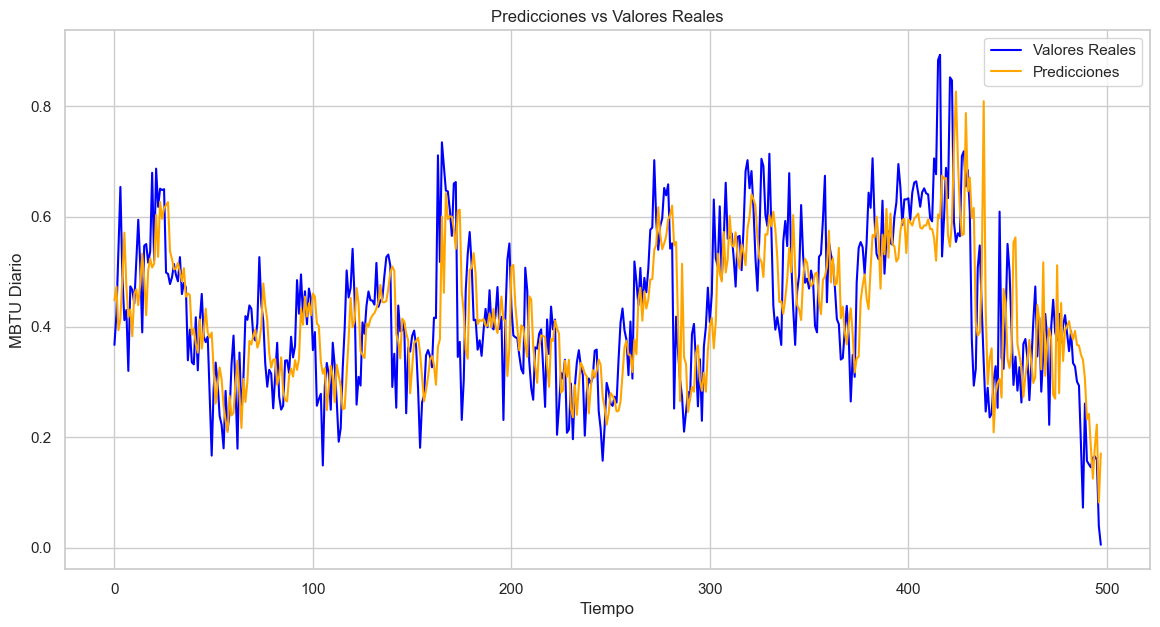

RMSE: 0.1042014063657296
MAE: 0.079713973311666
MAPE: 28.00%


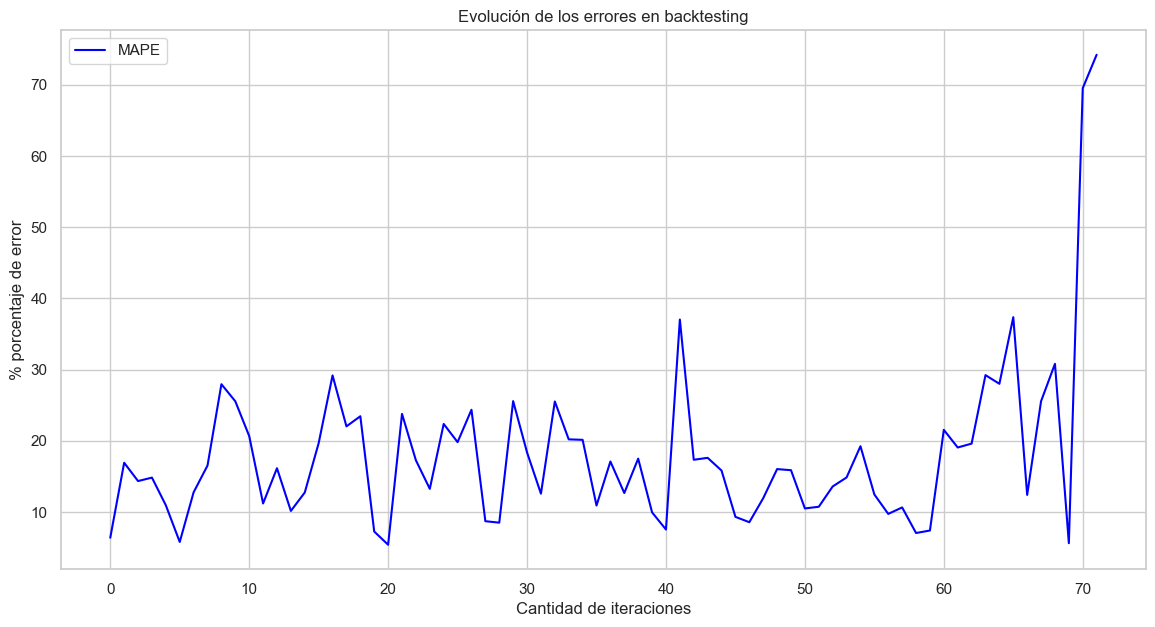

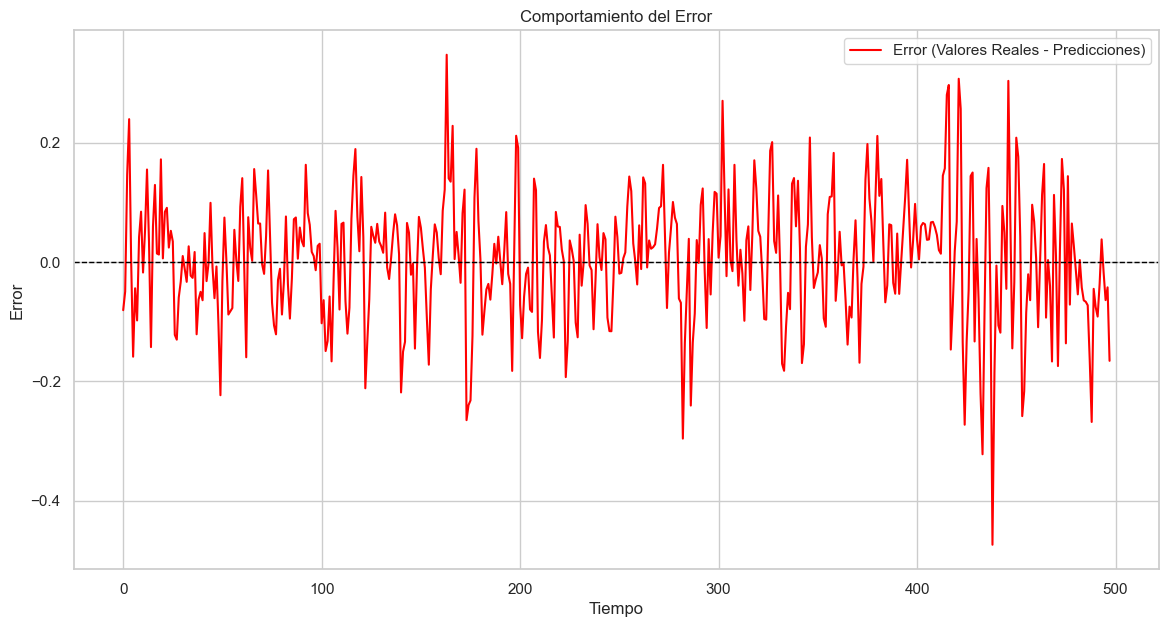

In [213]:
# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(14, 7))
plt.plot(y_test[time_step:], label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.legend()
plt.show()

# Evaluar el error
# Calcular métricas de evaluación
rmse = np.sqrt(np.mean((predictions.flatten() - y_test[time_step:].flatten()) ** 2))
mae = np.mean(np.abs(predictions.flatten() - y_test[time_step:].flatten()))
mape = np.mean(np.abs((predictions.flatten() - y_test[time_step:].flatten()) / y_test[time_step:].flatten())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

# Visualizar la evolución del MAPE
plt.figure(figsize=(14, 7))
plt.plot(MAPE, label='MAPE', color='blue')
plt.title('Evolución de los errores en backtesting')
plt.xlabel('Cantidad de iteraciones')
plt.ylabel('% porcentaje de error')
plt.legend()
plt.show()

# Opcional: Gráfico del error
errors = y_test[time_step:] - predictions
plt.figure(figsize=(14, 7))
plt.plot(errors, label='Error (Valores Reales - Predicciones)', color='red')
plt.axhline(0, color='black', lw=1, ls='--')
plt.title('Comportamiento del Error')
plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.legend()
plt.show()


In [210]:
X_test_mbtu

array([[0.41336201, 0.47504653, 0.55902517, ..., 0.46960323, 0.49775322,
        0.45393988],
       [0.47504653, 0.55902517, 0.4358024 , ..., 0.49775322, 0.45393988,
        0.43462481],
       [0.55902517, 0.4358024 , 0.46960323, ..., 0.45393988, 0.43462481,
        0.41799334],
       ...,
       [0.07241085, 0.261156  , 0.157097  , ..., 0.14534989, 0.16288331,
        0.1653639 ],
       [0.261156  , 0.157097  , 0.15086096, ..., 0.16288331, 0.1653639 ,
        0.15908388],
       [0.157097  , 0.15086096, 0.14534989, ..., 0.1653639 , 0.15908388,
        0.03920156]])

## **BackTesting para otros modelos**

In [215]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

c:\Users\itco10302\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(p, d, q), seasonal_order=(P, D, Q, s), maxiter=200),
             )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          exog                  = data[['exog_1', 'exog_2']],
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

metric